In [1]:
import os, shutil
import io
from io import StringIO
import re
import sys
from contextlib import redirect_stdout
from keras import models
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
import cnn_utilities as cn
from sklearn import metrics
import csv


Using TensorFlow backend.


In [3]:
# load trained model and normalization values
my_model = models.load_model("saved_models/train_128batch_15epoch_R0_sampleRate_migrationRate.hdf5")

my_root_model = models.load_model("saved_models/train_128batch_15epoch_root_location.hdf5", compile = False)
my_root_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', 
                      metrics = ['acc', tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalCrossentropy()])

mean_sd = pd.read_csv("saved_models/train_128batch_15epoch_normalization_label_mean_sd.csv", 
                     index_col = 0).to_numpy()

train_means = mean_sd[0,:]
train_sd = mean_sd[1,:]
train_aux_priors_means = train_means[3:,]
train_aux_priors_sd = train_sd[3:,]

num_locs = 5
max_tips = 502


In [174]:
phylo_comparison_data = pd.read_csv("data_files/phylocomp_100min.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()

phylo_comparison_labels = pd.read_csv("data_files/phylocomp_100min_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()

phylo_post = pd.read_table("data_files/phylocomp_100min_rates.postmeans", 
                   header = None, index_col = 0, error_bad_lines = False).to_numpy()

phylo_post_root_freq = pd.read_table("data_files/phylocomp_100min_root_probs.tsv", 
                   header = None, index_col = 0, error_bad_lines = False).to_numpy()



In [175]:
########################################
# comapre APE of CNN to that of phylo ##
########################################
# revbayes output
phylo_labels = phylo_comparison_labels.copy()[:,5:8]

phylo_post_ape = 100 * np.abs((phylo_labels - phylo_post)/phylo_labels)

# compute and gather auxilliary prior data
phylocomp_subsample_prop = phylo_comparison_data[:,(max_tips-1) * 7]
phylocomp_mu = phylo_comparison_data[:,(max_tips - 3) * 7]
phylocomp_num_tips = cn.get_num_tips(phylo_comparison_data)

aux_phylocomp = np.vstack((phylocomp_mu, phylocomp_subsample_prop, phylocomp_num_tips,
                          phylo_comparison_labels[:,8], phylo_comparison_labels[:,9])).transpose()

norm_aux_phylocomp = cn.normalize(aux_phylocomp, (train_aux_priors_means, train_aux_priors_sd))


# create input tensors
phylocomp_treeLocation_tensor, phylocomp_prior_tensor = cn.create_data_tensors(data = phylo_comparison_data, 
                                                                                    mu = norm_aux_phylocomp[:,0],
                                                                                    subsample_prop = norm_aux_phylocomp[:,1],
                                                                                    num_tips = norm_aux_phylocomp[:,2],
                                                                                    tmrca = norm_aux_phylocomp[:,3],
                                                                                    mean_bl = norm_aux_phylocomp[:,4],
                                                                                    num_locs = num_locs,
                                                                                    max_tips = max_tips,
                                                                                    cblv_contains_mu_rho = True)



In [176]:
# PREDICT R0, sample rate, migration rate
phylocomp_normalized_preds = my_model.predict([phylocomp_treeLocation_tensor, phylocomp_prior_tensor])

# reversing normalization
cnn_phylocomp_preds = cn.denormalize(phylocomp_normalized_preds, train_means[0:3], train_sd[0:3])
cnn_phylocomp_preds = np.exp(cnn_phylocomp_preds)

# PREDICT root location
phylocomp_root_loc_preds = my_root_model.predict([phylocomp_treeLocation_tensor, phylocomp_prior_tensor])

In [177]:
# my hacky way of getting precise estimates of run time for cnn predictions for single trees
shape1 = 1
shape2 = phylocomp_treeLocation_tensor.shape[1]
shape3 = phylocomp_treeLocation_tensor.shape[2]

predict_times = []
for i in range(0,phylocomp_treeLocation_tensor.shape[0]):
    f = io.StringIO()
    with redirect_stdout(f):
        my_model.predict([np.repeat(phylocomp_treeLocation_tensor[i,:,:].reshape((shape1,shape2,shape3)), 100, axis =0),
                          np.repeat(phylocomp_prior_tensor[i,:,:].reshape(1,5,2), 100, axis = 0)], verbose = 1)
    out = f.getvalue()
    
    reout = re.search("[0-9]+[um]s", out).group()
    reout = reout.replace('ms','000')
    reout = reout.replace('us','')
    predict_times.append(float(reout)/100)
    

df_predict_times = pd.DataFrame(predict_times, columns = None)
df_predict_times.to_csv('output/phylocomp_cnn_pred_times.tsv', sep = "\t", index = False)


In [178]:
# save predictions to file for analysis in R cuz I suck at python
# CNN predictions
df_phylocomp_cnn_output = pd.DataFrame(np.concatenate((cnn_phylocomp_preds, phylocomp_root_loc_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_phylocomp_cnn_output.to_csv('output/phylocomp_cnn_preds.tsv', sep = "\t", index = False)

# true values
df_phylocomp_true_output = pd.DataFrame(np.concatenate((phylo_post, phylo_post_root_freq), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_phylocomp_true_output.to_csv('output/phylocomp_phylo_means.tsv', sep = '\t', index = False)

# Phylogeographical predictions
df_phylocomp_phylo_output = pd.DataFrame(np.concatenate((phylo_comparison_labels[:,5:8], phylo_comparison_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_phylocomp_phylo_output.to_csv('output/phylocomp_labels.tsv', sep = '\t', index = False)



CNN auc cross-ent and median acc:  0.979477859291056 0.43122834526565706 0.9792376160621643
Phy auc cross-ent and median acc:  0.9873307380258378 0.35000425901685545 0.948


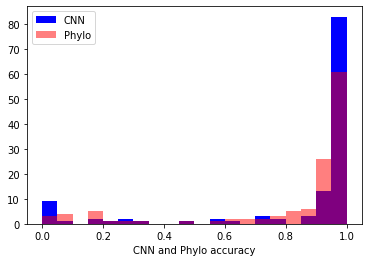

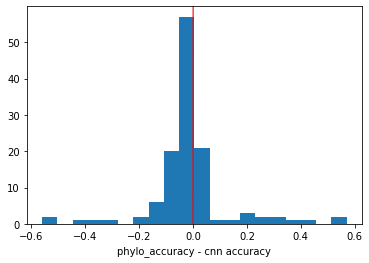

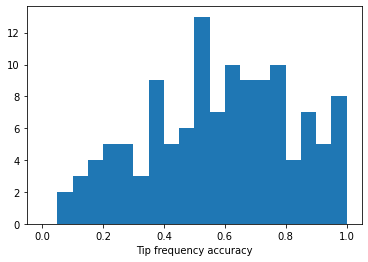

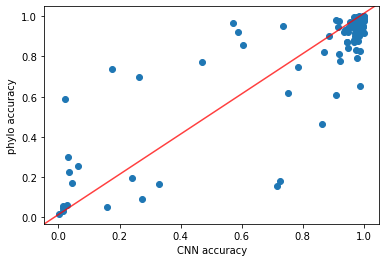

15


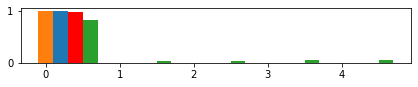

63


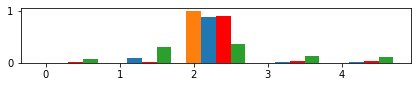

45


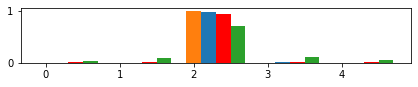

25


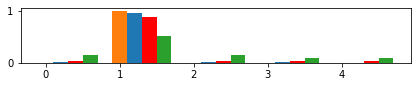

9


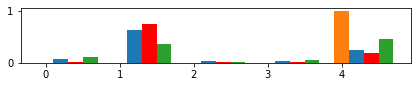

89


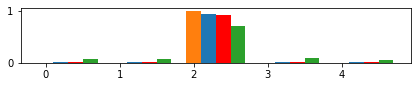

32


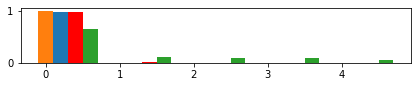

105


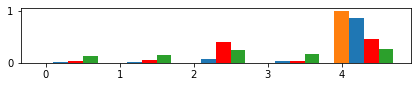

6


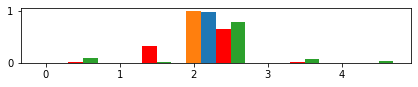

42


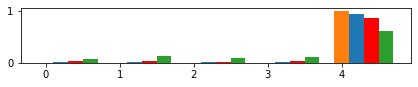

In [179]:
# make summary plots of root location predictions
accuracy_tipfreq, tip_loc_distro = cn.tip_freq_accuracy(phylocomp_treeLocation_tensor, phylo_comparison_labels, num_locs = 5)

cnn_root_accuracy, cnn_root_auc, cnn_root_crossentropy = cn.summarize_categorical_performance(phylo_comparison_labels[:,:5],
                                                                                            phylocomp_root_loc_preds)
phylo_root_accuracy, phylo_root_auc, phylo_root_crossentropy = cn.summarize_categorical_performance(phylo_comparison_labels[:,:5],
                                                                                            phylo_post_root_freq)

print("CNN auc cross-ent and median acc: ", cnn_root_auc, cnn_root_crossentropy, np.median(cnn_root_accuracy) )
print("Phy auc cross-ent and median acc: ", phylo_root_auc, phylo_root_crossentropy, np.median(phylo_root_accuracy))
cn.root_summary_plots(cnn_root_accuracy, phylo_root_accuracy, accuracy_tipfreq)
cn.plot_root_pred_examples(phylo_comparison_labels[:,0:5], phylocomp_root_loc_preds, phylo_post_root_freq, tip_loc_distro, 
                           num_plots = 10, num_locs = 5)


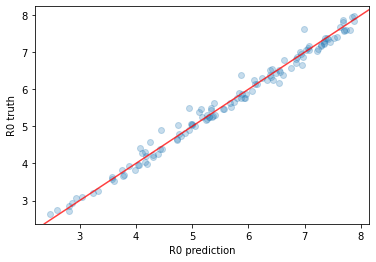

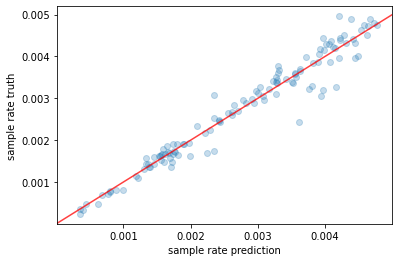

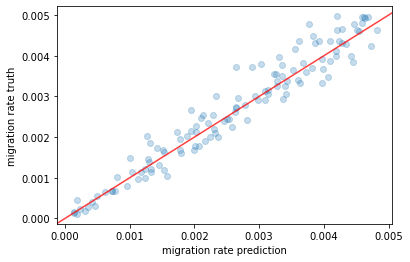

(124, 3)

In [180]:
cn.plot_preds_labels(cnn_phylocomp_preds, phylo_comparison_labels[:,5:8])
cnn_phylocomp_preds.shape

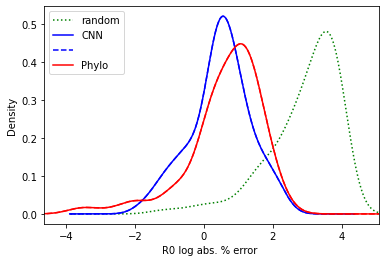

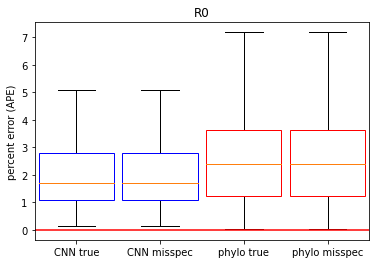

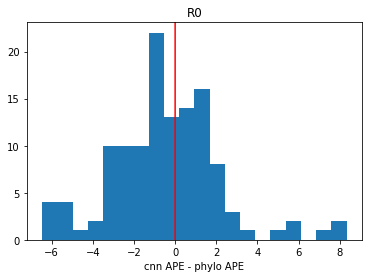

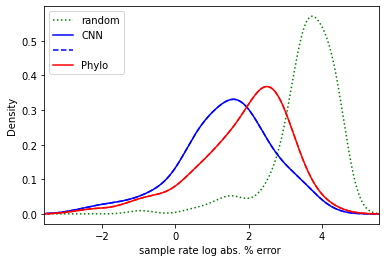

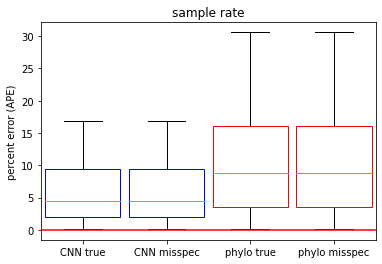

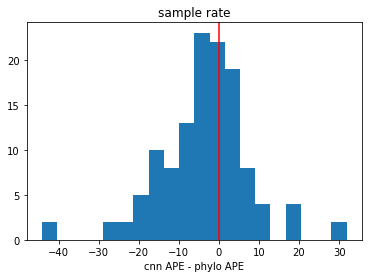

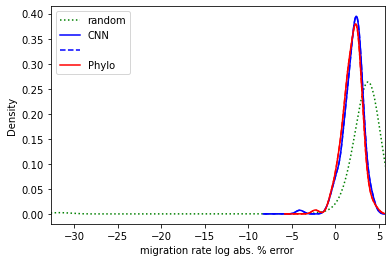

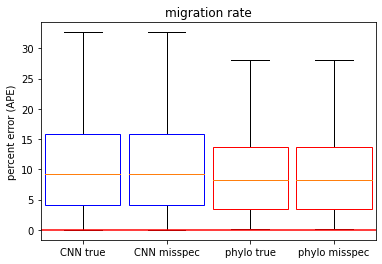

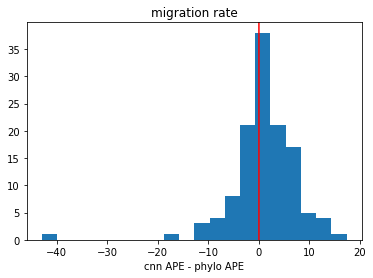

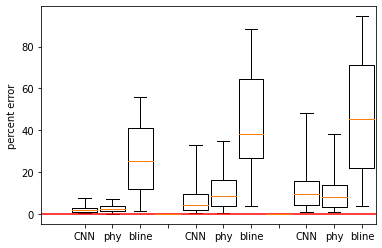

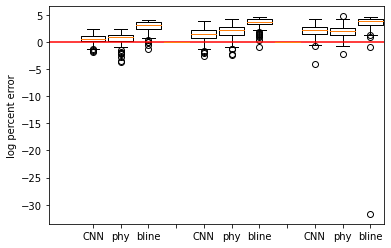

In [181]:
# make summary plots regression predictions
cnn_phylocomp_ape = 100 * np.abs((cnn_phylocomp_preds - phylo_labels)/phylo_labels)
mean_bl_R0 = 2 + (8 - 2)/2
mean_bl_delta = 0.0001 + (0.005 - 0.0001)/2
mean_bl_migration = 0.0001 + (0.005 - 0.0001)/2
mean_bl_R0_ape = 100 * np.abs(phylo_labels[:, 0] - mean_bl_R0)/mean_bl_R0
mean_bl_sample_ape = 100 * np.abs(phylo_labels[:, 1] - mean_bl_delta)/mean_bl_delta
mean_bl_migration_ape = 100 * np.abs(phylo_labels[:, 2] - mean_bl_migration)/mean_bl_migration
baseline_ape = np.column_stack((mean_bl_R0_ape, mean_bl_sample_ape, mean_bl_migration_ape))


cn.make_experiment_density_plots(cnn_phylocomp_ape, phylo_post_ape,
                       cnn_phylocomp_ape, phylo_post_ape, baseline_ape,
                          plot_legend = ["random", "CNN", "", "Phylo", ])

# make log-scale box plots
all_error_for_plotting = [cnn_phylocomp_ape[:,0],phylo_post_ape[:,0],baseline_ape[:,0], 0,
            cnn_phylocomp_ape[:,1],phylo_post_ape[:,1],baseline_ape[:,1], 0,
            cnn_phylocomp_ape[:,2],phylo_post_ape[:,2],baseline_ape[:,2]]

plt.boxplot(all_error_for_plotting,
           widths=0.9,
            labels = ["CNN", "phy", "bline", "",
                     "CNN", "phy", "bline", "",
                     "CNN", "phy", "bline"], 
            whis = (2.5, 97.5), showfliers = False)

plt.axline((0,0),slope=0,color="red")
plt.ylabel("percent error")
plt.show()


plt.boxplot([np.log(cnn_phylocomp_ape[:,0]), np.log(phylo_post_ape[:,0]), np.log(baseline_ape[:,0]), 0,
            np.log(cnn_phylocomp_ape[:,1]), np.log(phylo_post_ape[:,1]), np.log(baseline_ape[:,1]), 0,
            np.log(cnn_phylocomp_ape[:,2]), np.log(phylo_post_ape[:,2]), np.log(baseline_ape[:,2])],
           widths=0.9,
            labels = ["CNN", "phy", "bline", "",
                     "CNN", "phy", "bline", "",
                     "CNN", "phy", "bline"])

plt.axline((0,0),slope=0,color="red")
plt.ylabel("log percent error")
    
plt.show()


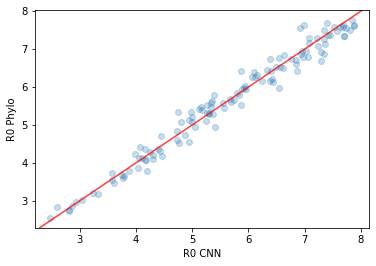

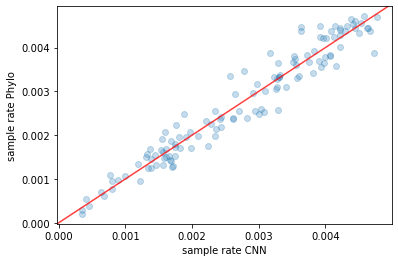

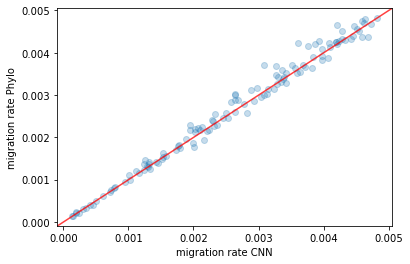

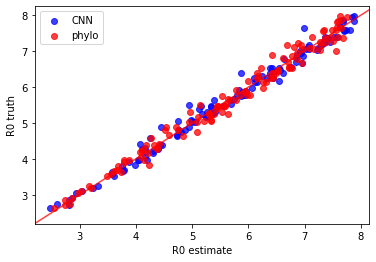

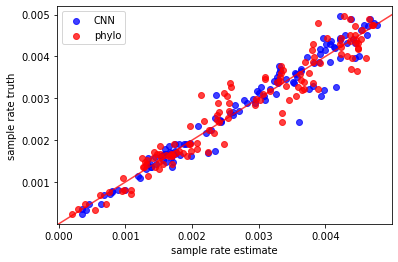

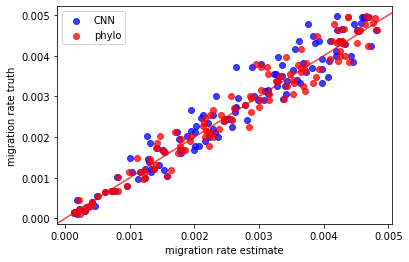

Ttest_indResult(statistic=-1.1732609620599477, pvalue=0.2418259165413189)
Ttest_indResult(statistic=-3.010464307004304, pvalue=0.0028800756360507634)
Ttest_indResult(statistic=0.7234190047757676, pvalue=0.4701097976960431)
KstestResult(statistic=0.23387096774193547, pvalue=0.002189056096735366)
KstestResult(statistic=0.28225806451612906, pvalue=9.326788889683897e-05)
KstestResult(statistic=0.10483870967741936, pvalue=0.5049573602047861)


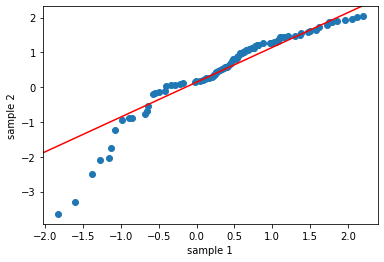

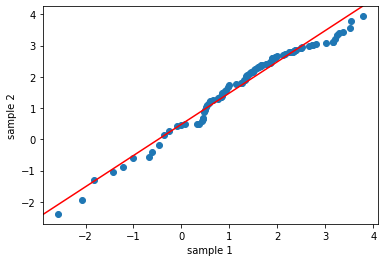

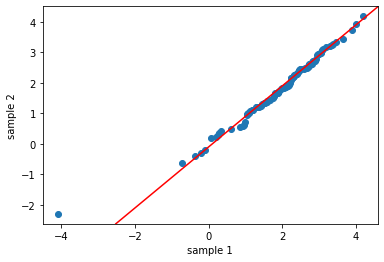

[None, None, None]

In [182]:
cn.plot_preds_labels(cnn_phylocomp_preds, phylo_post,
                         param_names = ["R0", "sample rate", "migration rate"],
                         axis_labels = ["CNN", "Phylo"])

cn.plot_overlaid_scatter(cnn_phylocomp_preds, phylo_post,
                         phylo_labels, 
                         param_names = ["R0", "sample rate", "migration rate"])

[print(sp.ttest_ind(np.log(cnn_phylocomp_ape[:,i]), np.log(phylo_post_ape[:,i]))) for i in range(0,3)]
[print(sp.kstest(np.log(cnn_phylocomp_ape[:,i]), np.log(phylo_post_ape[:,i]))) for i in range(0,3)]
[cn.qq_plot(np.log(cnn_phylocomp_ape[:,i]), np.log(phylo_post_ape[:,i]), num_quantiles = 100) for i in range(0,3)]

In [183]:
# print percent absolute error medians

# look into wasserstein distances from baseline: scipy.stats.wasserstein_distance()

print("R0")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_phylocomp_ape[:,0] - phylo_post_ape[:,0]))
print(np.median(phylo_post_ape[:,0]), np.quantile(phylo_post_ape[:,0], [0.025, 0.975]))
print(np.median(cnn_phylocomp_ape[:,0]), np.quantile(cnn_phylocomp_ape[:,0], [0.025, 0.975]))
print(np.median(baseline_ape[:,0]), np.quantile(baseline_ape[:,0], [0.025, 0.975]))
# bins = np.arange(1,10, step = 0.5)[0]
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_phylocomp_ape[:,0], bins=bins),  np.histogram(mean_bl_R0_ape, bins=bins))/ 
#                        sp.entropy(np.histogram(phylo_post_ape[:,0], np.histogram(mean_bl_R0_ape)))
print("delta")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_phylocomp_ape[:,1] - phylo_post_ape[:,1]))
print(np.median(phylo_post_ape[:,1]), np.quantile(phylo_post_ape[:,1], [0.025, 0.975]))
print(np.median(cnn_phylocomp_ape[:,1]), np.quantile(cnn_phylocomp_ape[:,1], [0.025, 0.975]))
print(np.median(baseline_ape[:,1]), np.quantile(baseline_ape[:,1], [0.025, 0.975]))
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_phylocomp_ape[:,1], bins=bins), np.histogram(mean_bl_sample_ape, bins=bins) ) / 
#                        sp.entropy(np.histogram(phylo_post_ape[:,1], bins=bins), np.histogram(mean_bl_sample_ape, bins=bins))))
print("migration")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_phylocomp_ape[:,2] - phylo_post_ape[:,2]))
print(np.median(phylo_post_ape[:,2]), np.quantile(phylo_post_ape[:,2], [0.025, 0.975]))
print(np.median(cnn_phylocomp_ape[:,2]), np.quantile(cnn_phylocomp_ape[:,2], [0.025, 0.975]))
print(np.median(baseline_ape[:,2]), np.quantile(baseline_ape[:,2], [0.025, 0.975]))
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_phylocomp_ape[:,2], bins=bins), np.histogram(mean_bl_migration_ape, bins=bins)) / 
#                        sp.entropy(np.histogram(phylo_post_ape[:,2], bins=bins), np.histogram(mean_bl_migration_ape, bins=bins))))

# cn.plot_preds_labels(phylo_post, phylo_labels)
# cn.plot_preds_labels(cnn_phylocomp_preds, phylo_labels)


R0
mean difference in APE (CNN_APE - Phylo_APE):  -0.4621152113136287
2.3977123802129574 [0.11644801 7.1798875 ]
1.7150996988232428 [0.26886727 8.19726698]
25.070400000000006 [ 1.06311 56.71911]
delta
mean difference in APE (CNN_APE - Phylo_APE):  -3.5483497721663766
8.733429886211514 [ 0.28760325 37.11194718]
4.403063295298471 [ 0.18512145 33.77130534]
38.03921568627452 [ 3.19607843 90.41176471]
migration
mean difference in APE (CNN_APE - Phylo_APE):  0.8592064379835579
8.212334606828506 [ 0.67745954 49.77966389]
9.305317960853662 [ 0.79256363 51.2039874 ]
45.29411764705883 [ 3.55882353 94.50980392]


In [184]:
im.reload(cn)

<module 'cnn_utilities' from 'C:\\Users\\ammon_work\\Desktop\\git_repos\\epi_geo_simulation\\neural_network_dev\\cnn_utilities.py'>

In [185]:
#########################################
# sample rate misspecified model trees ##
#########################################
misspec_delta_data = pd.read_csv("data_files/misspec_delta.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()
# load labels data
misspec_delta_labels = pd.read_csv("data_files/misspec_delta_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()

# phylo mean prediction file
miss_phylo_post_mean = pd.read_table("data_files/misspec_delta_rates.postmeans", 
                                    index_col=0, header = None).to_numpy()

misspec_delta_phylo_root = pd.read_table("data_files/misspec_delta_root_probs.tsv", 
                                   header = None, index_col = 0).to_numpy()



In [186]:

#########################
# prepare input tensors #
#########################


# normalize with training means and sds
misspec_delta_subsample_prop = misspec_delta_data[:,(max_tips-1) * 7]
misspec_delta_mu = misspec_delta_data[:,(max_tips-3) * 7]
misspec_delta_num_tips = cn.get_num_tips(misspec_delta_data)
misspec_delta_tmrca = misspec_delta_labels[:,8]
misspec_delta_mean_bl = misspec_delta_labels[:,9]

aux_misspec_delta = np.vstack((misspec_delta_mu, misspec_delta_subsample_prop, misspec_delta_num_tips,
                              misspec_delta_tmrca, misspec_delta_mean_bl)).transpose()
norm_aux_misspec_delta = cn.normalize(aux_misspec_delta, (train_aux_priors_means, train_aux_priors_sd))

misspec_delta_treeLocation_tensor, misspec_delta_prior_tensor = cn.create_data_tensors(misspec_delta_data,
                                                                          mu = norm_aux_misspec_delta[:,0],
                                                                          subsample_prop = norm_aux_misspec_delta[:,1],
                                                                            num_tips = norm_aux_misspec_delta[:,2],
                                                                            tmrca = norm_aux_misspec_delta[:,3],
                                                                            mean_bl = norm_aux_misspec_delta[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)

In [187]:
# predict
misspec_delta_normalized_preds = my_model.predict([misspec_delta_treeLocation_tensor, 
                                         misspec_delta_prior_tensor])

# denormalize preds use label means and sd from training data normalization
misspec_delta_denormalized_preds = cn.denormalize(misspec_delta_normalized_preds, train_means[0:3], train_sd[0:3])
misspec_delta_denormalized_preds = np.exp(misspec_delta_denormalized_preds)

# measure error
miss_abserror = np.abs(np.subtract(misspec_delta_denormalized_preds, misspec_delta_labels[:,5:8]))
miss_mape = np.multiply(100, np.abs(np.divide(miss_abserror, misspec_delta_labels[:,5:8])))

# PREDICT root location
misspec_delta_root_loc_preds = my_root_model.predict([misspec_delta_treeLocation_tensor, misspec_delta_prior_tensor])


In [188]:
train_means

array([ 1.71621202e+00, -6.03045137e+00, -6.21974654e+00,  3.33536913e-02,
        7.28413237e-01,  4.14536841e+02,  7.22094371e+01,  1.20160615e+01])

In [189]:
############################
# save predictions to file #
############################
# CNN predictions
df_misspec_delta_cnn_output = pd.DataFrame(np.concatenate((misspec_delta_denormalized_preds, misspec_delta_root_loc_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_delta_cnn_output.to_csv('output/misspec_delta_cnn_preds.tsv', sep = "\t", index = False)

# Phylogeographical predictions
df_misspec_delta_true_output = pd.DataFrame(np.concatenate((miss_phylo_post_mean, misspec_delta_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_delta_true_output.to_csv('output/misspec_delta_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_delta_phylo_output = pd.DataFrame(np.concatenate((misspec_delta_labels[:,5:8], misspec_delta_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_delta_phylo_output.to_csv('output/misspec_delta_labels.tsv', sep = '\t', index = False)


CNN auc cross-ent and median acc:  0.9136408471502762 0.9835924769483381 0.9647667109966278
Phy auc cross-ent and median acc:  0.9393853964561181 0.695352070520008 0.9319999999999999


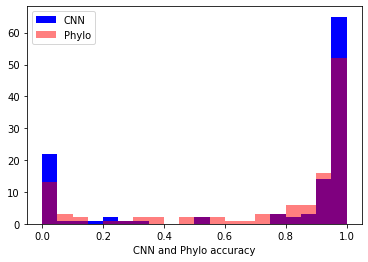

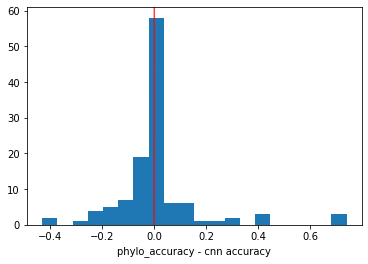

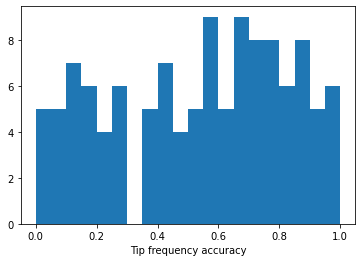

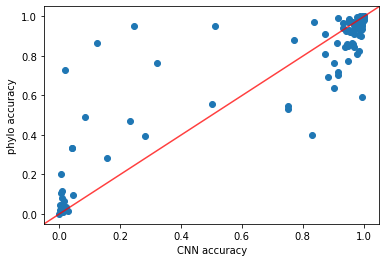

110


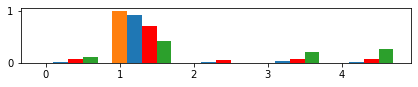

73


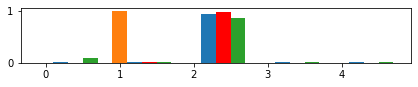

17


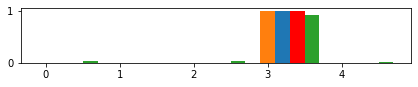

5


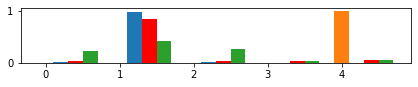

102


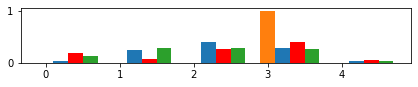

95


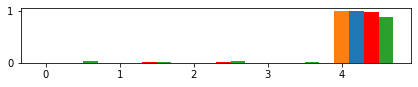

50


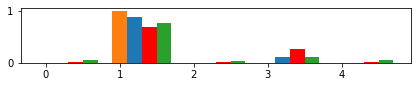

90


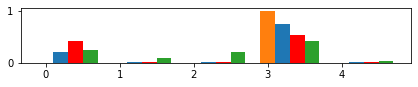

51


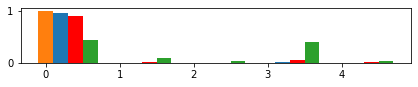

66


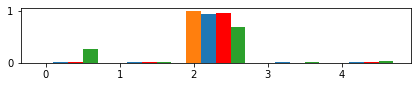

In [190]:
# make summary plots of root location predictions
# NOTE: see cnn_utilities.py for cat cross-entropy tolerance setting (for 0 and 1)
# summarize results
misspec_delta_accuracy_tipfreq, misspec_delta_tip_loc_distro = cn.tip_freq_accuracy(misspec_delta_treeLocation_tensor, 
                                                        misspec_delta_labels, num_locs = 5)
misspec_delta_cnn_root_accuracy, misspec_delta_cnn_root_auc, misspec_delta_cnn_root_crossentropy = cn.summarize_categorical_performance(misspec_delta_labels[:,:5],
                                                                                            misspec_delta_root_loc_preds)
misspec_delta_phylo_root_accuracy, misspec_delta_phylo_root_auc, misspec_delta_phylo_root_crossentropy = cn.summarize_categorical_performance(misspec_delta_labels[:,:5],
                                                                                            misspec_delta_phylo_root)

print("CNN auc cross-ent and median acc: ", 
      misspec_delta_cnn_root_auc, 
      misspec_delta_cnn_root_crossentropy, 
      np.median(misspec_delta_cnn_root_accuracy) )
print("Phy auc cross-ent and median acc: ", 
      misspec_delta_phylo_root_auc, 
      misspec_delta_phylo_root_crossentropy, 
      np.median(misspec_delta_phylo_root_accuracy))

# plotting
cn.root_summary_plots(misspec_delta_cnn_root_accuracy, 
                      misspec_delta_phylo_root_accuracy, 
                      misspec_delta_accuracy_tipfreq)
cn.plot_root_pred_examples(misspec_delta_labels[:,0:5], 
                           misspec_delta_root_loc_preds, 
                           misspec_delta_phylo_root, 
                           misspec_delta_tip_loc_distro, 
                           num_plots = 10, num_locs = 5)


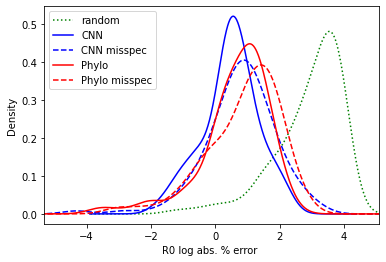

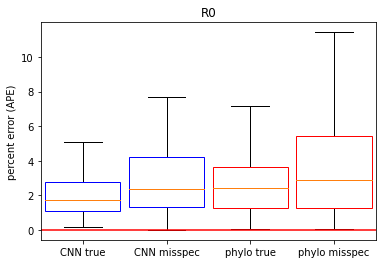

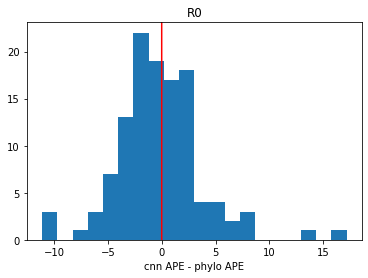

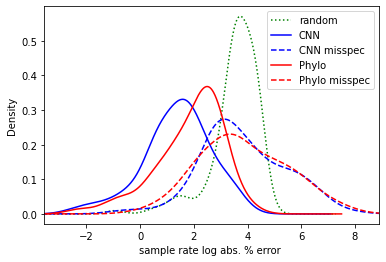

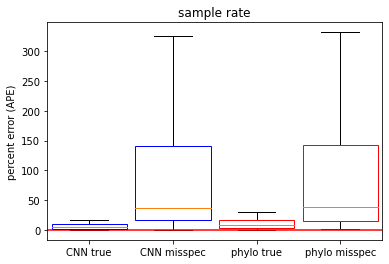

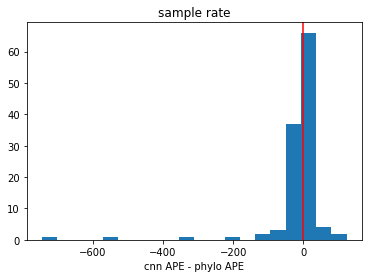

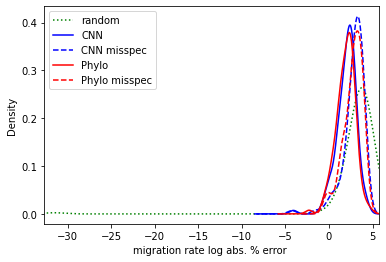

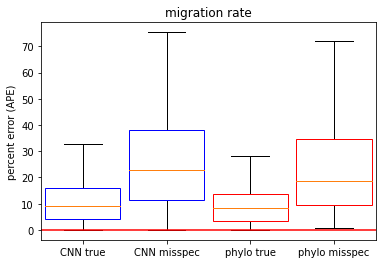

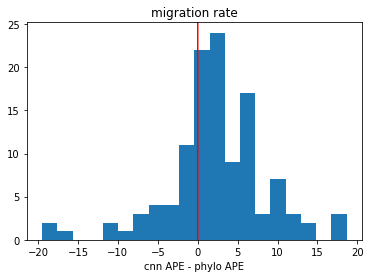

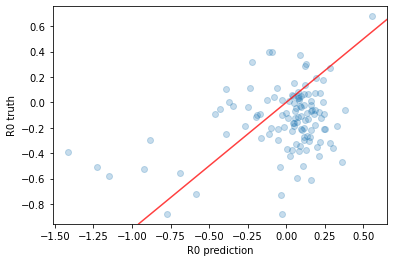

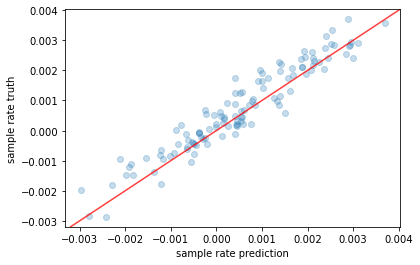

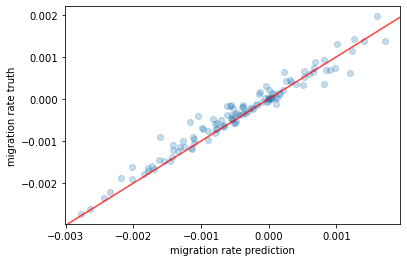

CNN R0:  1.3984368368467743
phylo R0:  8.690965684764745


In [191]:
# compute absolute percent error
miss_phylo_abserror = np.abs(np.subtract(miss_phylo_post_mean, misspec_delta_labels[:,5:8]))
miss_phylo_mape = np.multiply(100, np.abs(np.divide(miss_phylo_abserror, misspec_delta_labels[:,5:8])))


# plot

cn.make_experiment_density_plots(cnn_phylocomp_ape, phylo_post_ape,
                       miss_mape, miss_phylo_mape, baseline_ape)

cn.plot_preds_labels((misspec_delta_denormalized_preds - misspec_delta_labels[:,5:8]), 
                     (miss_phylo_post_mean - misspec_delta_labels[:,5:8]))

print("CNN R0: " , np.median(cnn_phylocomp_ape) - np.median(miss_mape[:,0]))
print("phylo R0: " , np.median(miss_phylo_mape) - np.median(phylo_post_ape[:,0]))

In [192]:
print("CNN R0: " , (np.median(miss_mape[:,0]) - np.median(cnn_phylocomp_ape[:,0])))
print("phylo R0: " , (np.median(miss_phylo_mape[:,0]) - np.median(phylo_post_ape[:,0])))

print("CNN m rate: " , (np.median(miss_mape[:,2]) - np.median(cnn_phylocomp_ape[:,2])))
print("phylo m rate: " , (np.median(miss_phylo_mape[:,2]) - np.median(phylo_post_ape[:,2])))

print("\n R0")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_mape[:,0] - miss_phylo_mape[:,0]))
print(np.median(miss_phylo_mape[:,0]), np.quantile(miss_phylo_mape[:,0], [0.025, 0.975]))
print(np.median(miss_mape[:,0]), np.quantile(miss_mape[:,0], [0.025, 0.975]))
print(np.median(baseline_ape[:,0]), np.quantile(baseline_ape[:,0], [0.025, 0.975]))
print("\n migration")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_mape[:,2] - miss_phylo_mape[:,2]))
print(np.median(miss_phylo_mape[:,2]), np.quantile(miss_phylo_mape[:,2], [0.025, 0.975]))
print(np.median(miss_mape[:,2]), np.quantile(miss_mape[:,2], [0.025, 0.975]))
print(np.median(baseline_ape[:,2]), np.quantile(baseline_ape[:,2], [0.025, 0.975]))


CNN R0:  0.665736358434089
phylo R0:  0.47892207503227446
CNN m rate:  13.429404200327832
phylo m rate:  10.412281322096714

 R0
median difference in APE (CNN_APE - Phylo_APE):  -0.194890035087816
2.876634455245232 [ 0.12385064 11.90011249]
2.3808360572573317 [ 0.23128106 13.16160126]
25.070400000000006 [ 1.06311 56.71911]

 migration
median difference in APE (CNN_APE - Phylo_APE):  2.236011030837221
18.62461592892522 [ 0.84120437 63.85339782]
22.734722161181494 [ 0.88019952 69.30730555]
45.29411764705883 [ 3.55882353 94.50980392]


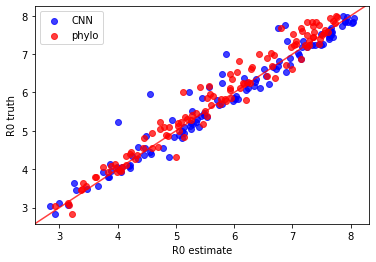

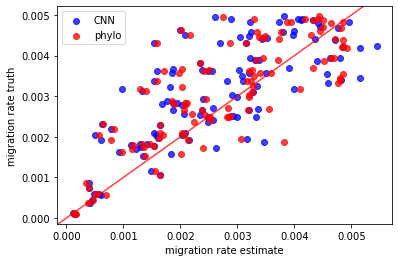

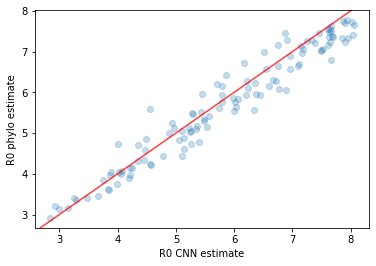

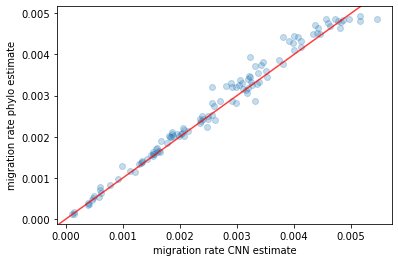

In [193]:
cn.plot_overlaid_scatter(misspec_delta_denormalized_preds[:,[0,2]], miss_phylo_post_mean[:,[0,2]],
                         misspec_delta_labels[:,5:8][:,[0,2]], 
                         param_names = ["R0", "migration rate"])

cn.plot_preds_labels((misspec_delta_denormalized_preds[:,[0,2]]), 
                     (miss_phylo_post_mean[:,[0,2]]), 
                     param_names = ["R0", "migration rate"], axis_labels = ['CNN estimate', 'phylo estimate'])

In [194]:
################################
# misspecified migration rate ##
################################
misspec_migration_data = pd.read_csv("data_files/misspec_m.cblv.csv", 
                   header =None, error_bad_lines = False, index_col=0).to_numpy()
# load labels data
misspec_migration_labels = pd.read_csv("data_files/misspec_m_labels.csv",
                    header = None, error_bad_lines = False, index_col = None).to_numpy()

# phylo prediction files
miss_migration_phylo_post_mean = pd.read_table("data_files/misspec_m_rates.postmeans",
                                              index_col=0, header = None).to_numpy()
misspec_migration_phylo_root = pd.read_table("data_files/misspec_m_root_probs.tsv", 
                                   header = None, index_col = 0).to_numpy()


In [195]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
misspec_migration_subsample_prop = misspec_migration_data[:,(max_tips-1) * 7]
misspec_migration_mu = misspec_migration_data[:,(max_tips-3) * 7]
misspec_migration_num_tips = cn.get_num_tips(misspec_migration_data)
misspec_migration_tmrca = misspec_migration_labels[:,8]
misspec_migration_mean_bl = misspec_migration_labels[:,9]

aux_misspec_migration = np.vstack((misspec_migration_mu, misspec_migration_subsample_prop, misspec_migration_num_tips,
                              misspec_migration_tmrca, misspec_migration_mean_bl)).transpose()
norm_aux_misspec_migration = cn.normalize(aux_misspec_migration, (train_aux_priors_means, train_aux_priors_sd))

misspec_migration_treeLocation_tensor, misspec_migration_prior_tensor = cn.create_data_tensors(misspec_migration_data,
                                                                          mu = norm_aux_misspec_migration[:,0],
                                                                          subsample_prop = norm_aux_misspec_migration[:,1],
                                                                            num_tips = norm_aux_misspec_migration[:,2],
                                                                            tmrca = norm_aux_misspec_migration[:,3],
                                                                            mean_bl = norm_aux_misspec_migration[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)


In [196]:
# predict phylodynamics
miss_migration_normalized_preds = my_model.predict([misspec_migration_treeLocation_tensor, 
                                         misspec_migration_prior_tensor])

# denormalize preds use label means and sd from training data normalization
miss_migration_denormalized_preds = cn.denormalize(miss_migration_normalized_preds, train_means[0:3], train_sd[0:3])
miss_migration_denormalized_preds = np.exp(miss_migration_denormalized_preds)

# measure error
miss_migration_abserror = np.abs(np.subtract(miss_migration_denormalized_preds, misspec_migration_labels[:,5:8]))
miss_migration_mape = np.multiply(100, np.abs(np.divide(miss_migration_abserror, misspec_migration_labels[:,5:8])))

# predict root location
miss_migration_root_preds = my_root_model.predict([misspec_migration_treeLocation_tensor, 
                                                          misspec_migration_prior_tensor])


In [197]:
############################
# save predictions to file #
############################
# CNN predictions
df_misspec_migration_cnn_output = pd.DataFrame(np.concatenate((miss_migration_denormalized_preds, miss_migration_root_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_cnn_output.to_csv('output/misspec_migration_cnn_preds.tsv', sep = "\t", index = False)

# Phylogeographical predictions
df_misspec_migration_true_output = pd.DataFrame(np.concatenate((miss_migration_phylo_post_mean, misspec_migration_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_true_output.to_csv('output/misspec_migration_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_migration_phylo_output = pd.DataFrame(np.concatenate((misspec_migration_labels[:,5:8], misspec_migration_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_phylo_output.to_csv('output/misspec_migration_labels.tsv', sep = '\t', index = False)


CNN auc cross-ent and median acc:  0.9582737672938315 0.6081346376434069 0.9692332148551941
Phy auc cross-ent and median acc:  0.9663662888292306 0.5221611157756181 0.9540000000000001


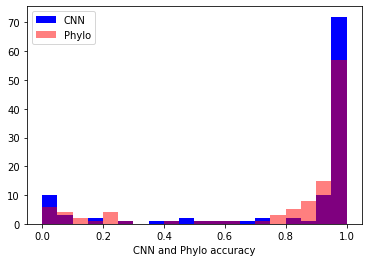

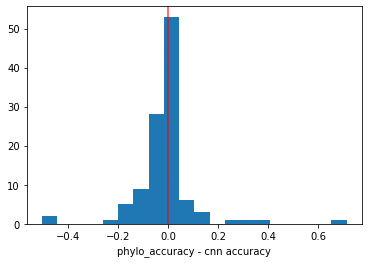

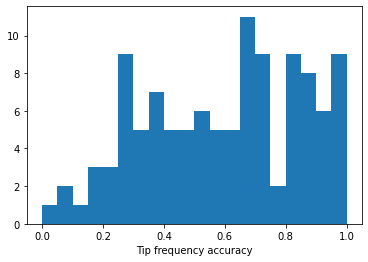

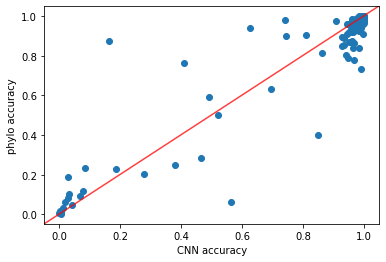

49


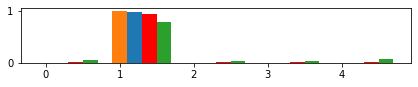

100


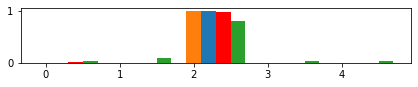

35


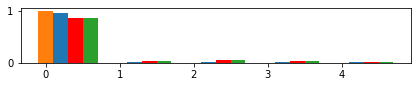

36


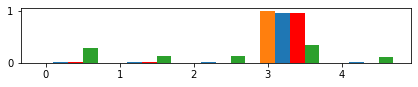

15


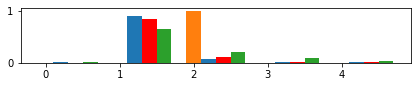

72


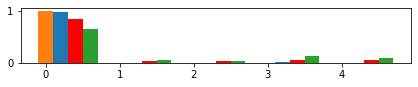

41


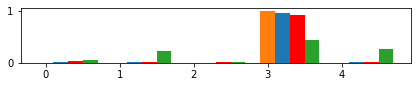

63


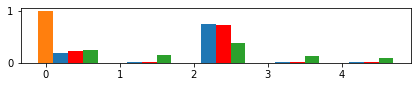

103


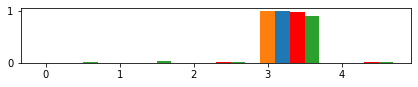

48


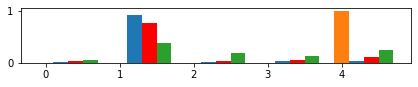

In [198]:
# make summary plots of root location predictions
# NOTE: see cnn_utilities.py for cat cross-entropy tolerance setting (for 0 and 1)
# summarize results
misspec_migration_accuracy_tipfreq, misspec_migration_tip_loc_distro = cn.tip_freq_accuracy(misspec_migration_treeLocation_tensor, 
                                                        misspec_migration_labels[:,0:5], num_locs = 5)
misspec_migration_cnn_root_accuracy, misspec_migration_cnn_root_auc, misspec_migration_cnn_root_crossentropy = cn.summarize_categorical_performance(misspec_migration_labels[:,:5],
                                                                                            miss_migration_root_preds)
misspec_migration_phylo_root_accuracy, misspec_migration_phylo_root_auc, misspec_migration_phylo_root_crossentropy = cn.summarize_categorical_performance(misspec_migration_labels[:,:5],
                                                                                            misspec_migration_phylo_root)

print("CNN auc cross-ent and median acc: ", 
      misspec_migration_cnn_root_auc, 
      misspec_migration_cnn_root_crossentropy, 
      np.median(misspec_migration_cnn_root_accuracy) )
print("Phy auc cross-ent and median acc: ", 
      misspec_migration_phylo_root_auc, 
      misspec_migration_phylo_root_crossentropy, 
      np.median(misspec_migration_phylo_root_accuracy))

# plotting
cn.root_summary_plots(misspec_migration_cnn_root_accuracy, 
                      misspec_migration_phylo_root_accuracy, 
                      misspec_migration_accuracy_tipfreq)
cn.plot_root_pred_examples(misspec_migration_labels[:,0:5], 
                           miss_migration_root_preds, 
                           misspec_migration_phylo_root, 
                           misspec_migration_tip_loc_distro, 
                           num_plots = 10, num_locs = 5)


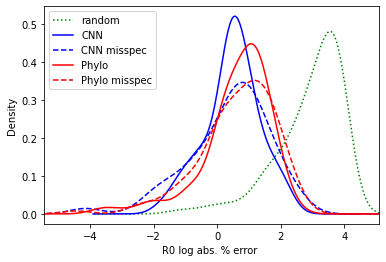

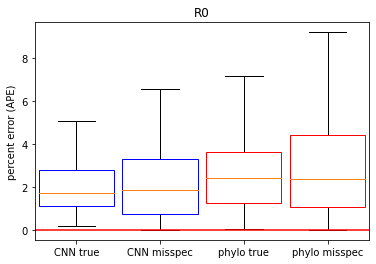

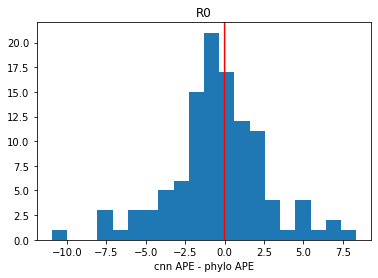

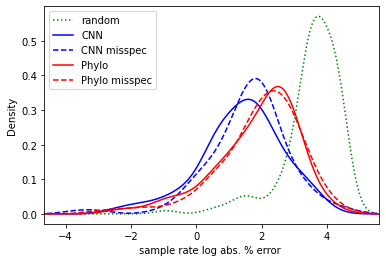

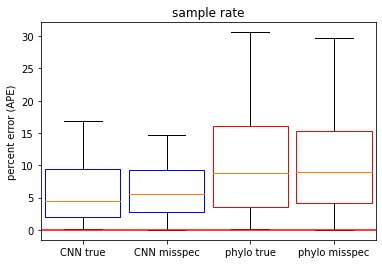

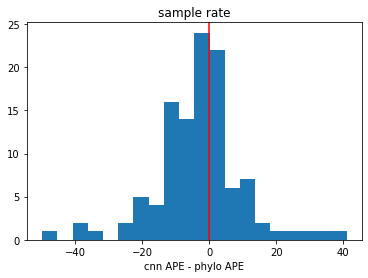

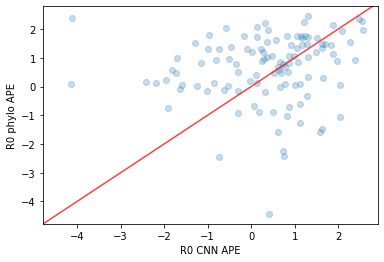

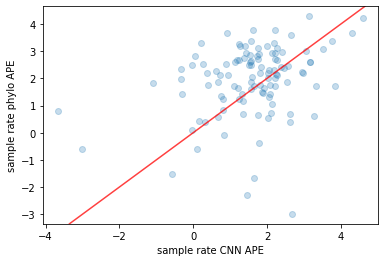

R0
median difference in APE (CNN_APE - Phylo_APE):  -0.4098577981825988
sample rate
median difference in APE (CNN_APE - Phylo_APE):  -1.35405529455734


In [199]:
# compute absolute percent error
miss_migration_phylo_abserror = np.abs(np.subtract(miss_migration_phylo_post_mean, 
                                                   misspec_migration_labels[:,5:8]))
miss_migration_phylo_mape = np.multiply(100, np.abs(np.divide(miss_migration_phylo_abserror, 
                                                              misspec_migration_labels[:,5:8])))


# plot
cn.make_experiment_density_plots(cnn_phylocomp_ape[:,[0,1]], phylo_post_ape[:,[0,1]],
                       miss_migration_mape[:,[0,1]], miss_migration_phylo_mape[:,[0,1]],
                           baseline_ape[:,[0,1]],
                                xlabel = ["R0", "sample rate"])

# correlation in error?
cn.plot_preds_labels(np.log(miss_migration_mape[:,[0,1]]), np.log(miss_migration_phylo_mape[:,[0,1]]), 
                     param_names = ["R0", "sample rate"], axis_labels = ['CNN APE', 'phylo APE'])

# summary
print("R0")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_migration_mape[:,0] - miss_migration_phylo_mape[:,0]))


print("sample rate")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_migration_mape[:,1] - miss_migration_phylo_mape[:,1]))


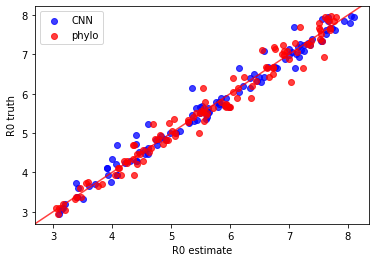

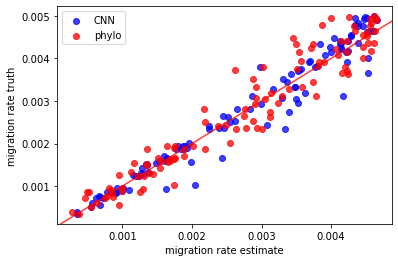

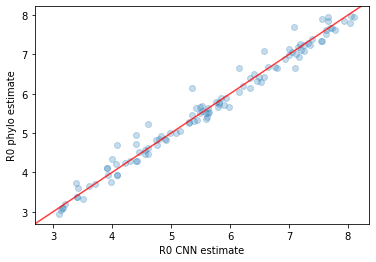

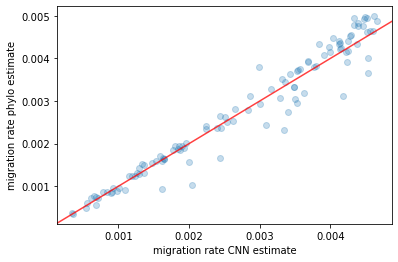

In [200]:
cn.plot_overlaid_scatter(miss_migration_denormalized_preds[:,[0,1]], miss_migration_phylo_post_mean[:,[0,1]],
                         misspec_migration_labels[:,[5,6]], 
                         param_names = ["R0", "migration rate"])

cn.plot_preds_labels((miss_migration_denormalized_preds[:,[0,1]]), 
                     (misspec_migration_labels[:,[5,6]]), 
                     param_names = ["R0", "migration rate"], axis_labels = ['CNN estimate', 'phylo estimate'])

In [201]:
print("CNN R0: " , (np.median(miss_migration_mape[:,0]) - np.median(cnn_phylocomp_ape[:,0])))
print("phylo R0: " , (np.median(miss_migration_phylo_mape[:,0]) - np.median(phylo_post_ape[:,0])))

print("CNN sample rate: " , (np.median(miss_migration_mape[:,1]) - np.median(cnn_phylocomp_ape[:,1])))
print("phylo sample rate: " , (np.median(miss_migration_phylo_mape[:,1]) - np.median(phylo_post_ape[:,1])))



CNN R0:  0.15730173901139333
phylo R0:  -0.027743577471686542
CNN sample rate:  1.229016657622985
phylo sample rate:  0.16193155957162553


In [12]:
#######################
## misspecified tree ##
#######################
# read cblv data
misspec_tree_cblv = pd.read_csv("data_files/misspec_tree.cblv.csv",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()

misspec_tree_param_labels = pd.read_csv("data_files/misspec_tree_labels.csv",
                                       header = None, error_bad_lines = False).to_numpy()

# read phylo data
misspec_tree_phylo = pd.read_table("data_files/misspec_tree_scale0.001_rates.postmeans",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()

misspec_tree_phylo_root = pd.read_table("data_files/misspec_tree_root_probs.tsv",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()


# tree distances data
tree_overlap = pd.read_table("data_files/phylo_estimates_files/proportion_branches_shared_scale0.001.txt",
                            header = None).to_numpy()



ERROR! Session/line number was not unique in database. History logging moved to new session 3097


In [13]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
misspectree_subsample_prop = misspec_tree_cblv[:,(max_tips-1) * 7]
misspectree_mu = misspec_tree_cblv[:,(max_tips-3) * 7]
misspectree_num_tips = cn.get_num_tips(misspec_tree_cblv)
misspectree_tmrca = misspec_tree_param_labels[:,8]
misspectree_mean_bl = misspec_tree_param_labels[:,9]

aux_misspectree = np.vstack((misspectree_mu, misspectree_subsample_prop, misspectree_num_tips,
                              misspectree_tmrca, misspectree_mean_bl)).transpose()
norm_aux_misspectree = cn.normalize(aux_misspectree, (train_aux_priors_means, train_aux_priors_sd))

misspectree_treeLocation_tensor, misspectree_prior_tensor = cn.create_data_tensors(misspec_tree_cblv,
                                                                          mu = norm_aux_misspectree[:,0],
                                                                          subsample_prop = norm_aux_misspectree[:,1],
                                                                            num_tips = norm_aux_misspectree[:,2],
                                                                            tmrca = norm_aux_misspectree[:,3],
                                                                            mean_bl = norm_aux_misspectree[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)








In [15]:
# predict
normed_misspec_tree_preds = my_model.predict([misspectree_treeLocation_tensor, 
                                              misspectree_prior_tensor])

# denormalize predictions
misspec_tree_preds = cn.denormalize(normed_misspec_tree_preds, train_means[0:3], train_sd[0:3])
misspec_tree_preds = np.exp(misspec_tree_preds)

# predict root location
misspec_tree_root_preds = my_root_model.predict([misspectree_treeLocation_tensor, 
                                                          misspectree_prior_tensor])


ERROR! Session/line number was not unique in database. History logging moved to new session 3099


In [16]:
############################
# save predictions to file #
############################

# Error trees
# CNN predictions
df_misspec_tree_cnn_output = pd.DataFrame(np.concatenate((misspec_tree_preds, misspec_tree_root_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_tree_cnn_output.to_csv('output/misspec_tree_cnn_preds.tsv', sep = "\t", index = False)

# Phylogeographical predictions
df_misspec_tree_true_output = pd.DataFrame(np.concatenate((misspec_tree_phylo, misspec_tree_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_tree_true_output.to_csv('output/misspec_tree_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_tree_phylo_output = pd.DataFrame(np.concatenate((misspec_tree_param_labels[:,5:8], misspec_tree_param_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_tree_phylo_output.to_csv('output/misspec_tree_labels.tsv', sep = '\t', index = False)



In [5]:
##################################
# misspecified number locations ##
##################################
misspec_numloc_data = pd.read_csv("data_files/misspec_numloc.cblv.csv", 
                   header =None, error_bad_lines = False, index_col=0).to_numpy()
# load labels data
misspec_numloc_labels = pd.read_csv("data_files/misspec_numloc_labels.txt",
                    header = None, error_bad_lines = False, index_col = None).to_numpy()

# phylo prediction files
miss_numloc_phylo_post_mean = pd.read_table("data_files/misspec_numloc_rates.postmeans",
                                               index_col=0, header = None).to_numpy()
misspec_numloc_phylo_root = pd.read_table("data_files/misspec_numloc_root_probs.tsv", 
                                   header = None, index_col = 0).to_numpy()

ERROR! Session/line number was not unique in database. History logging moved to new session 3095


In [6]:
# prepare input tensors #

# normalize with training means and sds
misspec_numloc_subsample_prop = misspec_numloc_data[:,(max_tips-1) * 7]
misspec_numloc_mu = misspec_numloc_data[:,(max_tips-3) * 7]
misspec_numloc_num_tips = cn.get_num_tips(misspec_numloc_data)
misspec_numloc_tmrca = misspec_numloc_labels[:,8]
misspec_numloc_mean_bl = misspec_numloc_labels[:,9]

aux_misspec_numloc = np.vstack((misspec_numloc_mu, misspec_numloc_subsample_prop, misspec_numloc_num_tips,
                              misspec_numloc_tmrca, misspec_numloc_mean_bl)).transpose()
norm_aux_misspec_numloc = cn.normalize(aux_misspec_numloc, (train_aux_priors_means, train_aux_priors_sd))

misspec_numloc_treeLocation_tensor, misspec_numloc_prior_tensor = cn.create_data_tensors(misspec_numloc_data,
                                                                          mu = norm_aux_misspec_numloc[:,0],
                                                                          subsample_prop = norm_aux_misspec_numloc[:,1],
                                                                            num_tips = norm_aux_misspec_numloc[:,2],
                                                                            tmrca = norm_aux_misspec_numloc[:,3],
                                                                            mean_bl = norm_aux_misspec_numloc[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)

In [9]:
# predict phylodynamics
miss_numloc_normalized_preds = my_model.predict([misspec_numloc_treeLocation_tensor, 
                                         misspec_numloc_prior_tensor])

# denormalize preds use label means and sd from training data normalization
miss_numloc_denormalized_preds = cn.denormalize(miss_numloc_normalized_preds, train_means[0:3], train_sd[0:3])
miss_numloc_denormalized_preds = np.exp(miss_numloc_denormalized_preds)

# measure error
miss_numloc_abserror = np.abs(np.subtract(miss_numloc_denormalized_preds, misspec_numloc_labels[:,5:8]))
miss_numloc_mape = np.multiply(100, np.abs(np.divide(miss_numloc_abserror, misspec_numloc_labels[:,5:8])))
miss_numloc_phylo_abserror = np.abs(np.subtract(miss_numloc_phylo_post_mean , misspec_numloc_labels[:,5:8] ))
miss_numloc_phylo_mape = np.multiply(100, np.abs(np.divide(miss_numloc_phylo_abserror, misspec_numloc_labels[:,5:8])))


# predict root location
miss_numloc_root_preds = my_root_model.predict([misspec_numloc_treeLocation_tensor, 
                                                          misspec_numloc_prior_tensor])

ERROR! Session/line number was not unique in database. History logging moved to new session 3096


In [10]:
############################
# save predictions to file #
############################
# CNN predictions
df_misspec_migration_cnn_output = pd.DataFrame(np.concatenate((miss_numloc_denormalized_preds, miss_numloc_root_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_cnn_output.to_csv('output/misspec_numloc_cnn_preds.tsv', sep = "\t", index = False)

# Phylogeographical predictions
df_misspec_migration_true_output = pd.DataFrame(np.concatenate((miss_numloc_phylo_post_mean, misspec_numloc_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_true_output.to_csv('output/misspec_numloc_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_migration_phylo_output = pd.DataFrame(np.concatenate((misspec_numloc_labels[:,5:8], misspec_numloc_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_phylo_output.to_csv('output/misspec_numloc_labels.tsv', sep = '\t', index = False)


In [202]:
####################
# misspecified R0 ##
####################
misspec_R0_data = pd.read_csv("data_files/misspec_R0.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()
# load labels data
misspec_R0_labels = pd.read_csv("data_files/misspec_R0_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()

# phylo prediction files
miss_R0_phylo_post_mean = pd.read_table("data_files/misspec_R0_rates.postmeans",
                                              index_col=0, header = None).to_numpy()
misspec_R0_phylo_root = pd.read_table("data_files/misspec_R0_root_probs.tsv", 
                                   header = None, index_col = 0).to_numpy()

In [203]:
misspec_R0_phylo_root.shape

(120, 5)

In [204]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
misspec_R0_subsample_prop = misspec_R0_data[:,(max_tips-1) * 7]
misspec_R0_mu = misspec_R0_data[:,(max_tips-3) * 7]
misspec_R0_num_tips = cn.get_num_tips(misspec_R0_data)
misspec_R0_tmrca = misspec_R0_labels[:,8]
misspec_R0_mean_bl = misspec_R0_labels[:,9]

aux_misspec_R0 = np.vstack((misspec_R0_mu, misspec_R0_subsample_prop, misspec_R0_num_tips,
                              misspec_R0_tmrca, misspec_R0_mean_bl)).transpose()
norm_aux_misspec_R0 = cn.normalize(aux_misspec_R0, (train_aux_priors_means, train_aux_priors_sd))

misspec_R0_treeLocation_tensor, misspec_R0_prior_tensor = cn.create_data_tensors(misspec_R0_data,
                                                                          mu = norm_aux_misspec_R0[:,0],
                                                                          subsample_prop = norm_aux_misspec_R0[:,1],
                                                                            num_tips = norm_aux_misspec_R0[:,2],
                                                                            tmrca = norm_aux_misspec_R0[:,3],
                                                                            mean_bl = norm_aux_misspec_R0[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)

In [205]:
# predict phylodynamics
miss_R0_normalized_preds = my_model.predict([misspec_R0_treeLocation_tensor, 
                                         misspec_R0_prior_tensor])

# denormalize preds use label means and sd from training data normalization
miss_R0_denormalized_preds = cn.denormalize(miss_R0_normalized_preds, train_means[0:3], train_sd[0:3])
miss_R0_denormalized_preds = np.exp(miss_R0_denormalized_preds)

# measure error
miss_R0_abserror = np.abs(np.subtract(miss_R0_denormalized_preds, misspec_R0_labels[:,5:8]))
miss_R0_mape = np.multiply(100, np.abs(np.divide(miss_R0_abserror, misspec_R0_labels[:,5:8])))

# predict root location
miss_R0_root_preds = my_root_model.predict([misspec_R0_treeLocation_tensor, 
                                                          misspec_R0_prior_tensor])

In [206]:
############################
# save predictions to file #
############################
# CNN predictions
df_misspec_R0_cnn_output = pd.DataFrame(np.concatenate((miss_R0_denormalized_preds, miss_R0_root_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_R0_cnn_output.to_csv('output/misspec_R0_cnn_preds.tsv', sep = "\t", index = False)

# # Phylogeographical predictions
df_misspec_R0_true_output = pd.DataFrame(np.concatenate((miss_R0_phylo_post_mean, misspec_R0_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_R0_true_output.to_csv('output/misspec_R0_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_R0_phylo_output = pd.DataFrame(np.concatenate((misspec_R0_labels[:,5:8], misspec_R0_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_R0_phylo_output.to_csv('output/misspec_R0_labels.tsv', sep = '\t', index = False)

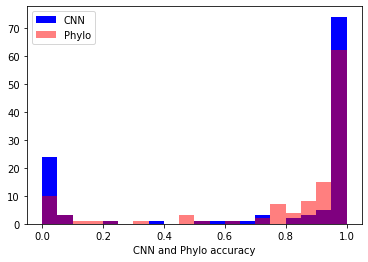

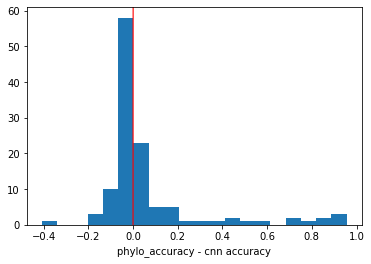

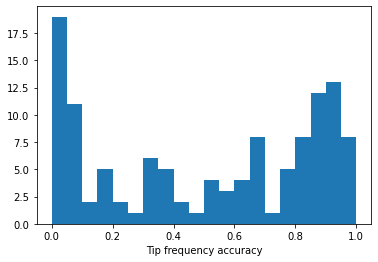

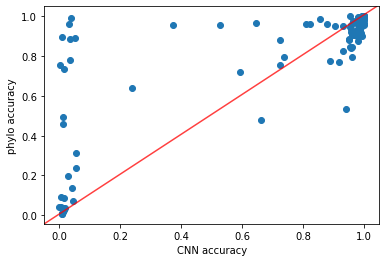

112


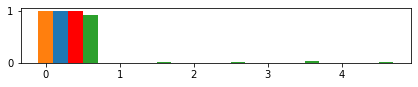

52


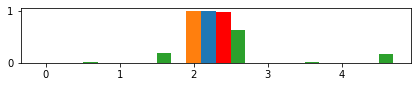

104


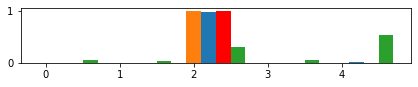

116


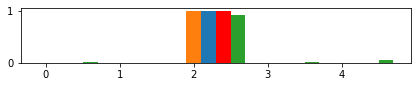

23


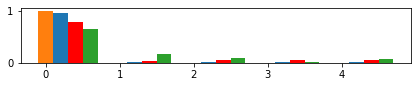

53


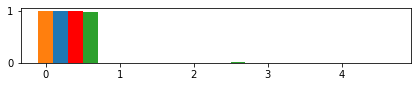

58


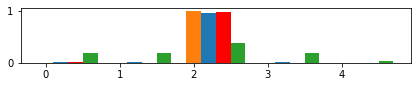

32


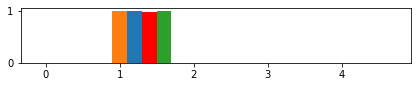

64


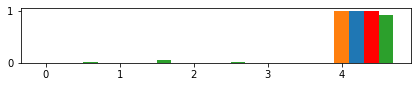

18


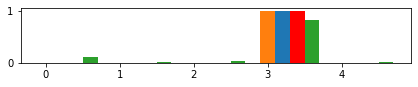

In [207]:
# make summary plots of root location predictions
# NOTE: see cnn_utilities.py for cat cross-entropy tolerance setting (for 0 and 1)
# summarize results
misspec_R0_accuracy_tipfreq, misspec_R0_tip_loc_distro = cn.tip_freq_accuracy(misspec_R0_treeLocation_tensor, 
                                                        misspec_R0_labels[:,0:5], num_locs = 5)
misspec_R0_cnn_root_accuracy, misspec_R0_cnn_root_auc, misspec_R0_cnn_root_crossentropy = cn.summarize_categorical_performance(misspec_R0_labels[:,:5],
                                                                                            miss_R0_root_preds)
misspec_R0_phylo_root_accuracy, misspec_R0_phylo_root_auc, misspec_R0_phylo_root_crossentropy = cn.summarize_categorical_performance(misspec_R0_labels[:,:5],
                                                                                            misspec_R0_phylo_root)

# plotting
cn.root_summary_plots(misspec_R0_cnn_root_accuracy, 
                      misspec_R0_phylo_root_accuracy, 
                      misspec_R0_accuracy_tipfreq)
cn.plot_root_pred_examples(misspec_R0_labels[:,0:5], 
                           miss_R0_root_preds, 
                           misspec_R0_phylo_root, 
                           misspec_R0_tip_loc_distro, 
                           num_plots = 10, num_locs = 5)

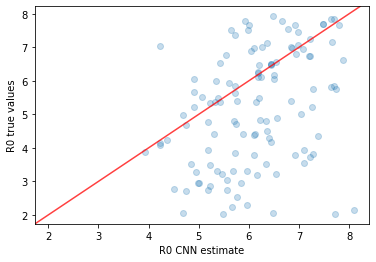

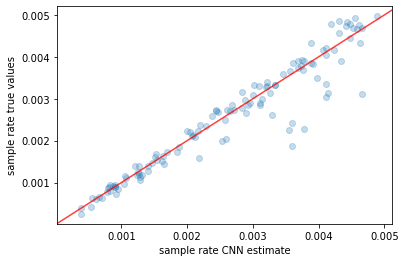

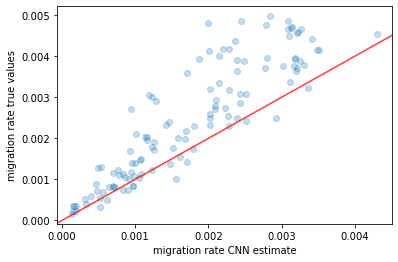

In [208]:
cn.plot_preds_labels((miss_R0_denormalized_preds[:,0:3]), 
                     (misspec_R0_labels[:,5:8]), 
                     param_names = ["R0", "sample rate", "migration rate"], 
                     axis_labels = ['CNN estimate', 'true values'])

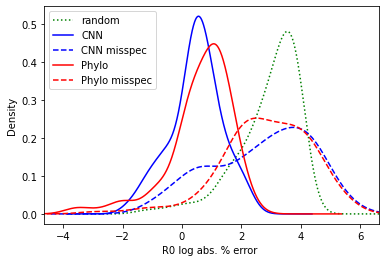

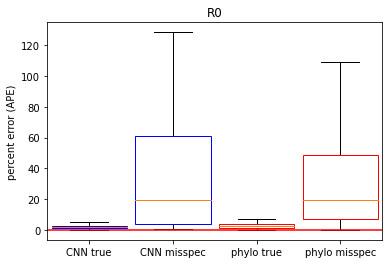

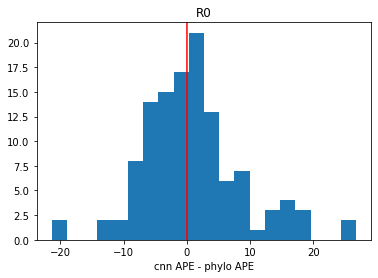

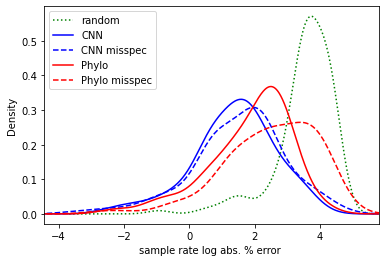

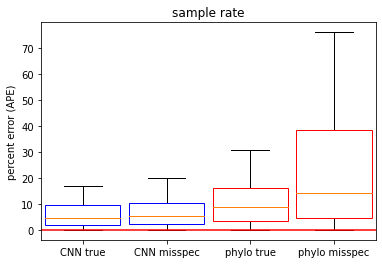

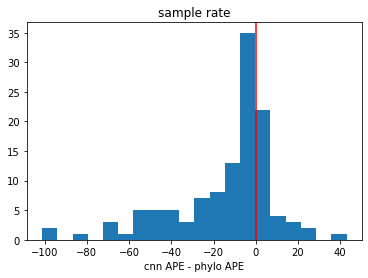

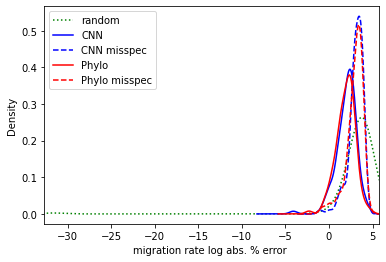

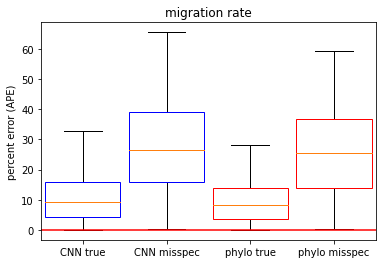

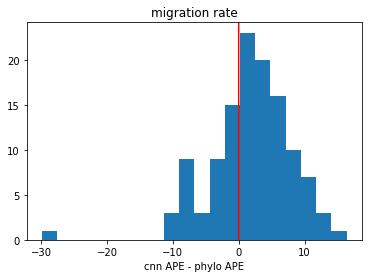

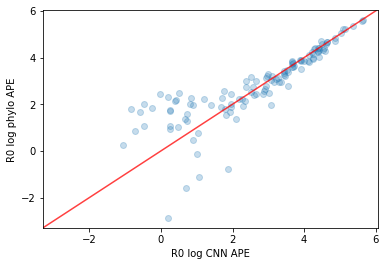

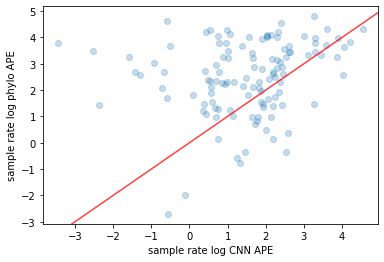

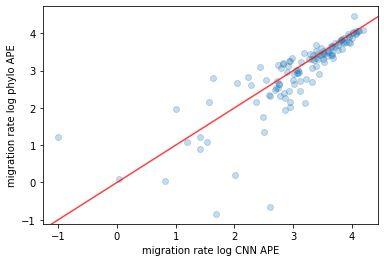

R0
median difference in APE (CNN_APE - Phylo_APE):  0.33582459920295094
sample rate
median difference in APE (CNN_APE - Phylo_APE):  -6.610283975931591
migration rate
median difference in APE (CNN_APE - Phylo_APE):  2.010987673474494


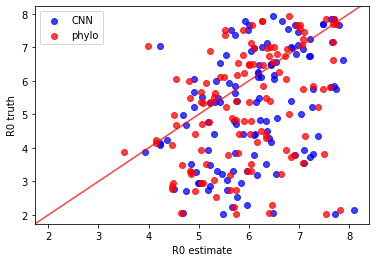

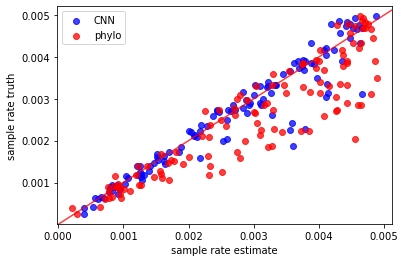

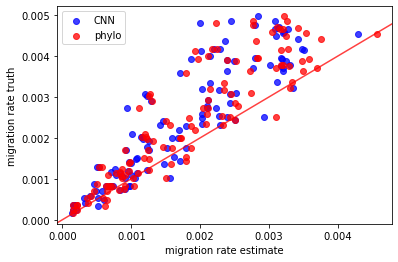

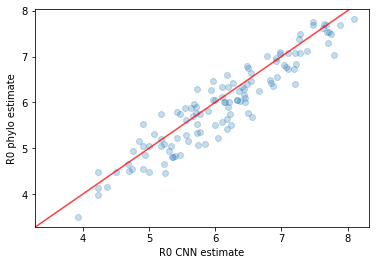

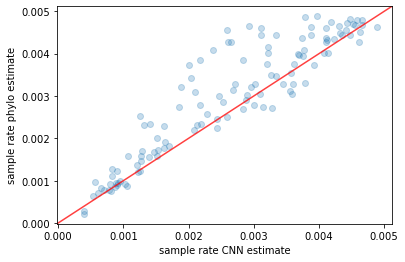

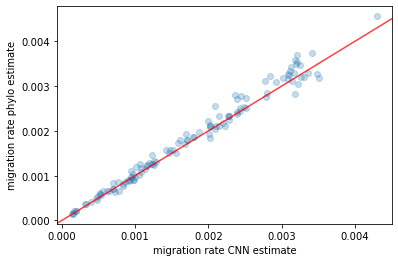

CNN R0:  17.903601524244234
phylo R0:  17.016900088585047
CNN sample rate:  1.0562600621112157
phylo sample rate:  5.472139002613192
CNN migration rate:  17.133478531844688
phylo migration rate:  17.276325066831156


In [209]:
# # compute absolute percent error
miss_R0_phylo_abserror = np.abs(np.subtract(miss_R0_phylo_post_mean, 
                                                   misspec_R0_labels[:,5:8]))
miss_R0_phylo_mape = np.multiply(100, np.abs(np.divide(miss_R0_phylo_abserror, 
                                                              misspec_R0_labels[:,5:8])))


# plot
cn.make_experiment_density_plots(cnn_phylocomp_ape[:,0:3], phylo_post_ape[:,0:3],
                       miss_R0_mape[:,0:3], miss_R0_phylo_mape[:,0:3],
                           baseline_ape[:,0:3],
                                xlabel = ["R0", "sample rate", "migration rate"])

# correlation in error?
cn.plot_preds_labels(np.log(miss_R0_mape[:,0:3]), np.log(miss_R0_phylo_mape[:,0:3]), 
                     param_names = ["R0", "sample rate", "migration rate"], axis_labels = ['log CNN APE', 'log phylo APE'])

# summary
print("R0")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_R0_mape[:,0] - miss_R0_phylo_mape[:,0]))


print("sample rate")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_R0_mape[:,1] - miss_R0_phylo_mape[:,1]))

print("migration rate")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_R0_mape[:,2] - miss_R0_phylo_mape[:,2]))

cn.plot_overlaid_scatter(miss_R0_denormalized_preds[:,0:3], miss_R0_phylo_post_mean[:,0:3],
                         misspec_R0_labels[:,5:8], 
                         param_names = ["R0", "sample rate", "migration rate"])

cn.plot_preds_labels((miss_R0_denormalized_preds[:,0:3]), 
                     (miss_R0_phylo_post_mean[:,0:3]), 
                     param_names = ["R0", "sample rate", "migration rate"], 
                     axis_labels = ['CNN estimate', 'phylo estimate'])

print("CNN R0: " , (np.median(miss_R0_mape[:,0]) - np.median(cnn_phylocomp_ape[:,0])))
print("phylo R0: " , (np.median(miss_R0_phylo_mape[:,0]) - np.median(phylo_post_ape[:,0])))

print("CNN sample rate: " , (np.median(miss_R0_mape[:,1]) - np.median(cnn_phylocomp_ape[:,1])))
print("phylo sample rate: " , (np.median(miss_R0_phylo_mape[:,1]) - np.median(phylo_post_ape[:,1])))

print("CNN migration rate: " , (np.median(miss_R0_mape[:,2]) - np.median(cnn_phylocomp_ape[:,2])))
print("phylo migration rate: " , (np.median(miss_R0_phylo_mape[:,2]) - np.median(phylo_post_ape[:,2])))

{'name': 'conv1d_105', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(3, 7, 64)
0


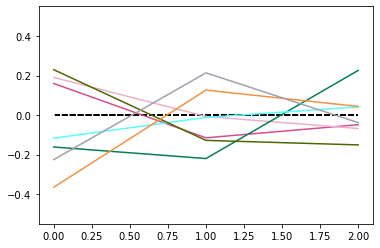

1


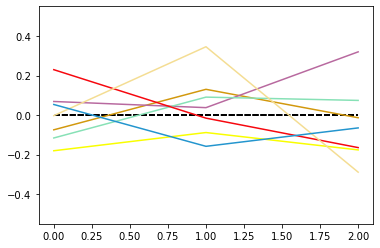

2


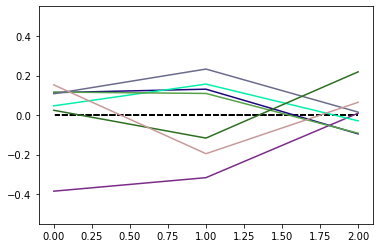

3


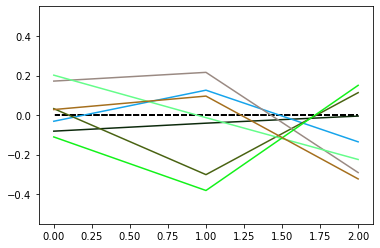

4


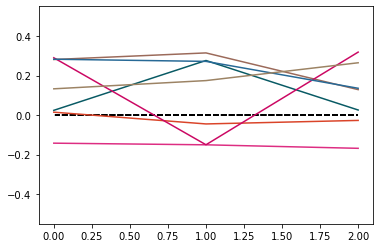

5


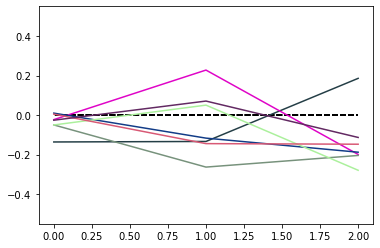

6


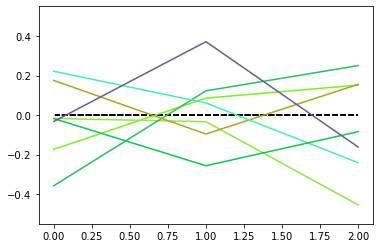

7


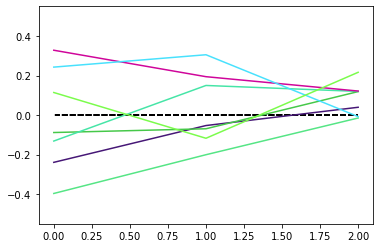

8


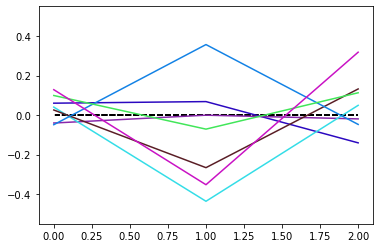

9


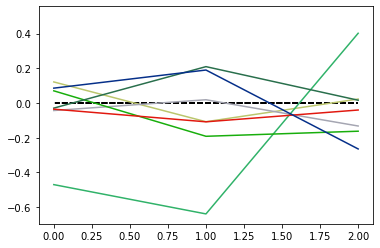

10


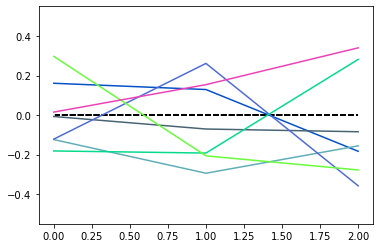

11


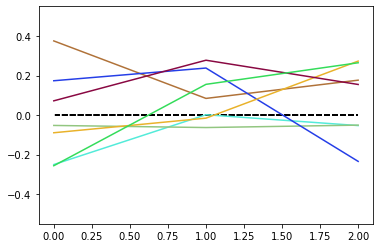

12


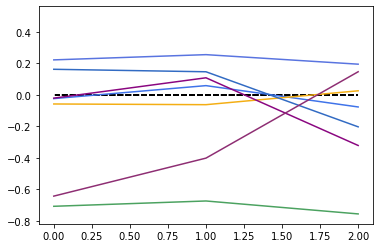

13


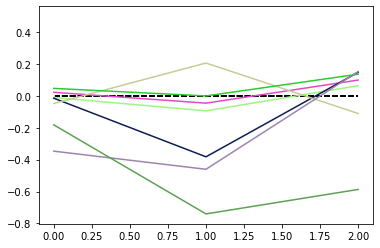

14


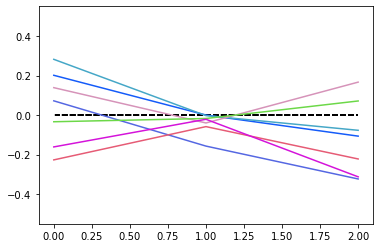

15


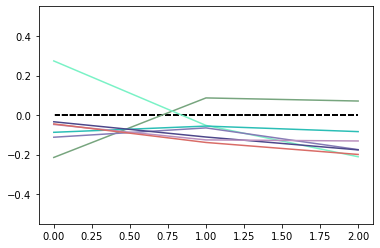

16


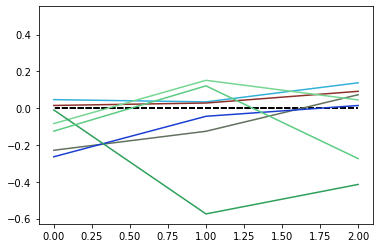

17


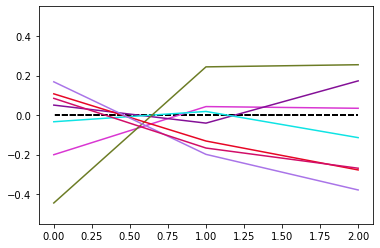

18


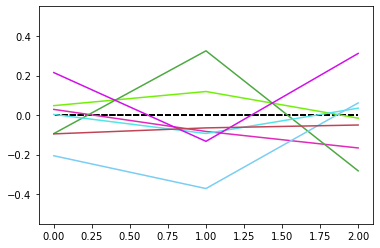

19


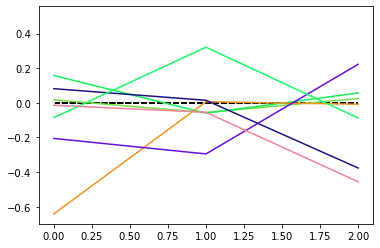

20


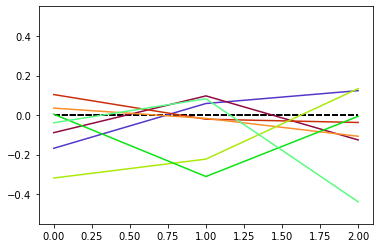

21


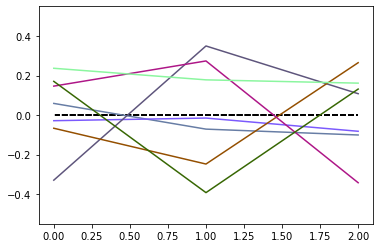

22


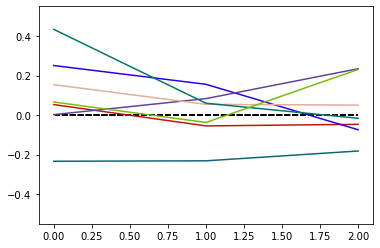

23


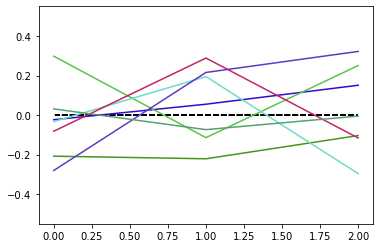

24


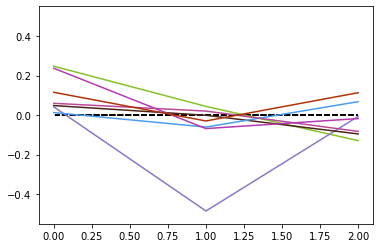

25


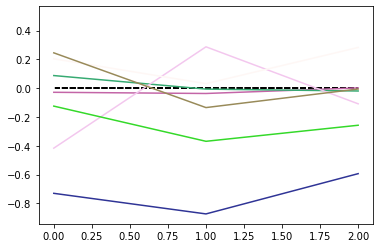

26


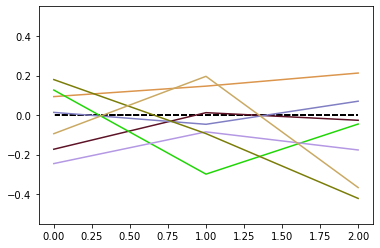

27


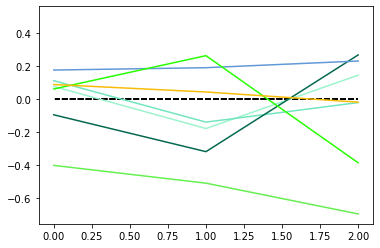

28


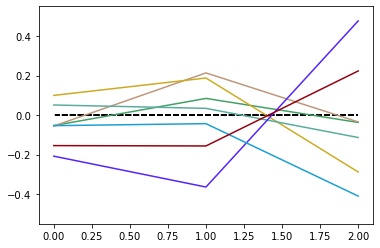

29


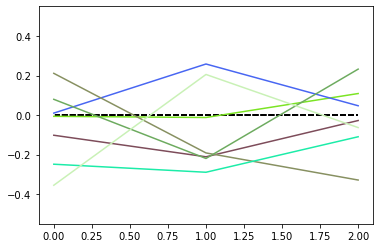

30


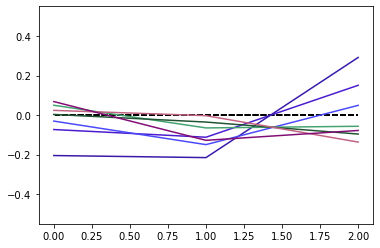

31


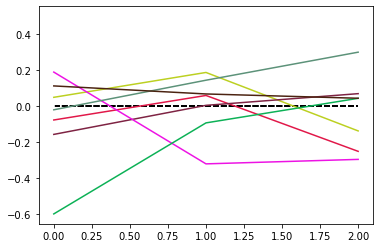

32


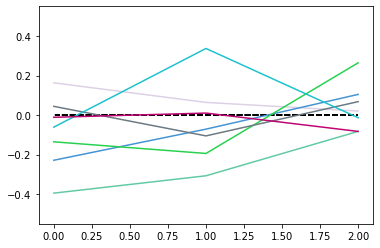

33


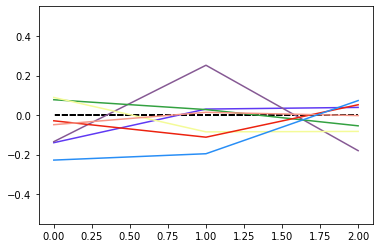

34


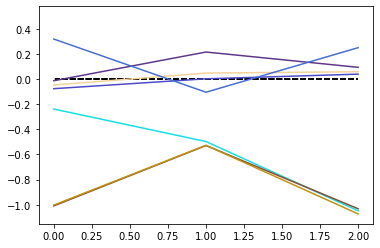

35


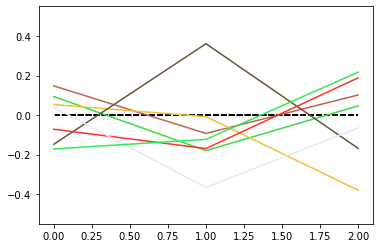

36


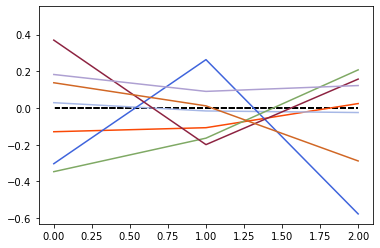

37


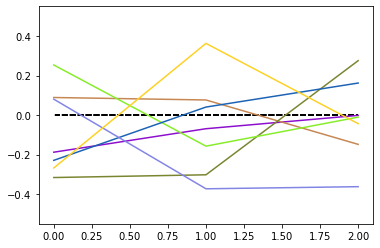

38


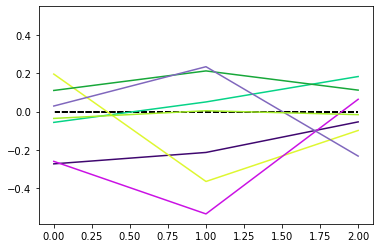

39


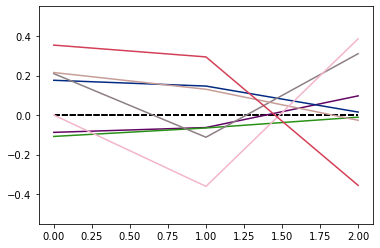

40


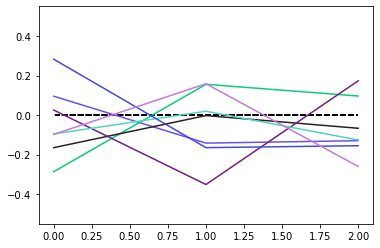

41


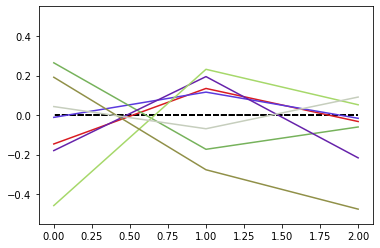

42


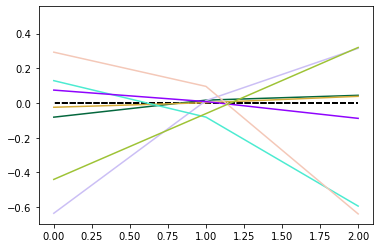

43


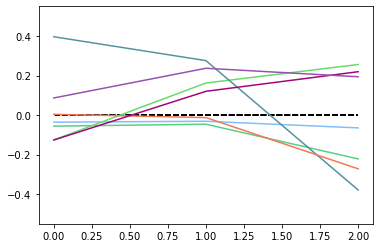

44


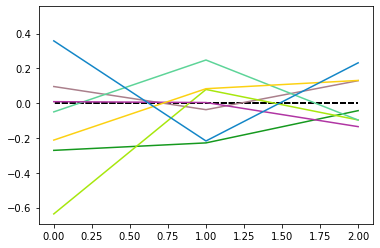

45


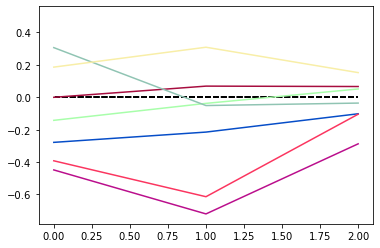

46


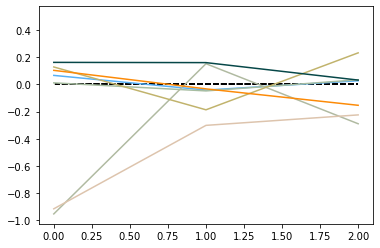

47


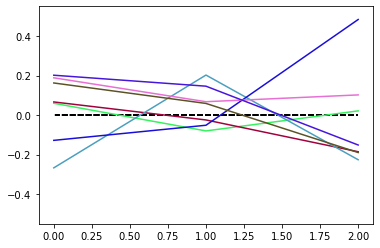

48


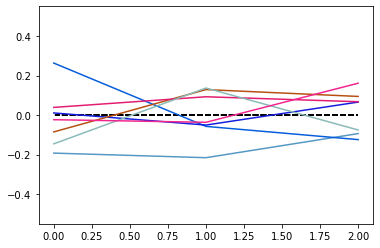

49


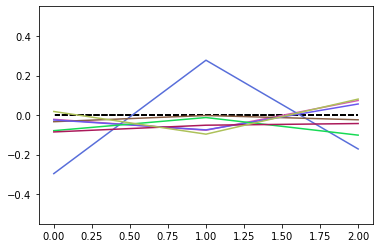

50


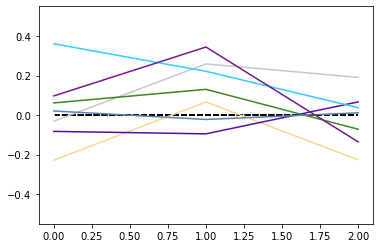

51


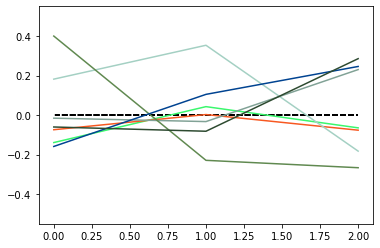

52


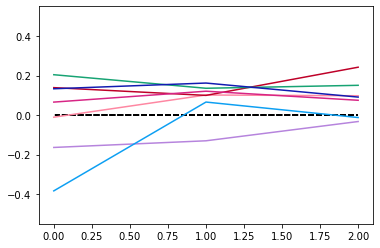

53


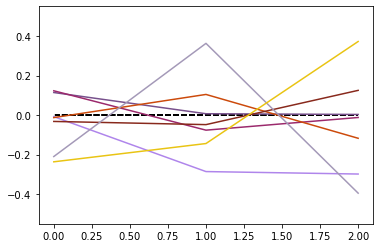

54


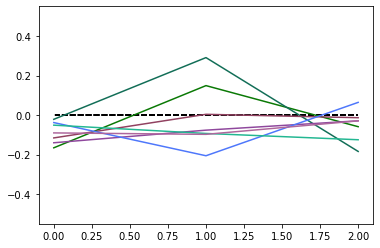

55


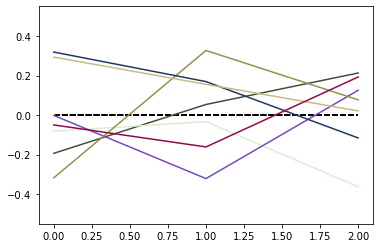

56


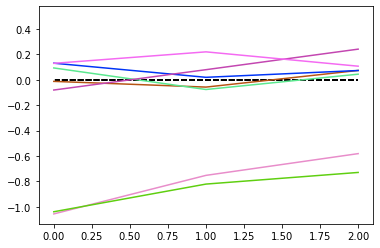

57


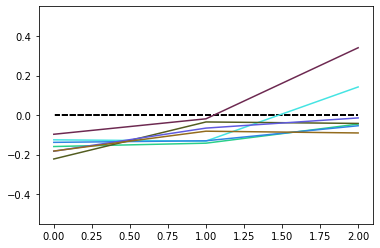

58


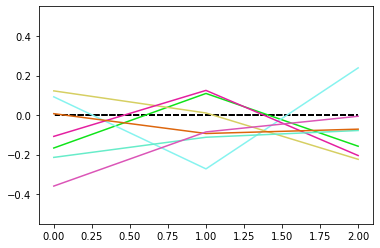

59


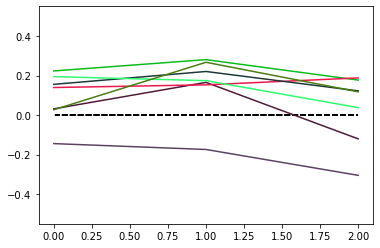

60


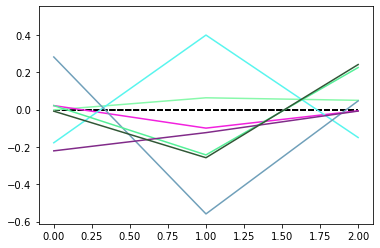

61


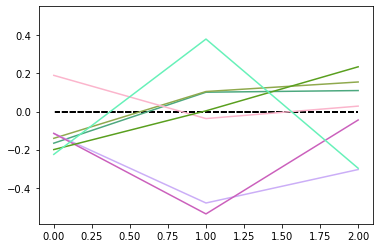

62


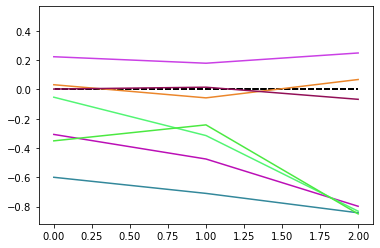

63


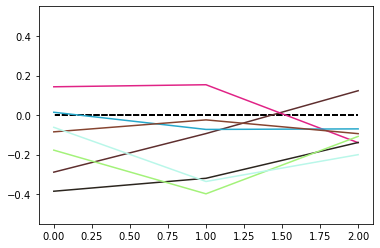

{'name': 'dense_53', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_in', 'distribution': 'normal', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(96, 64)
0


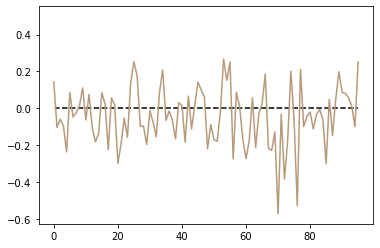

1


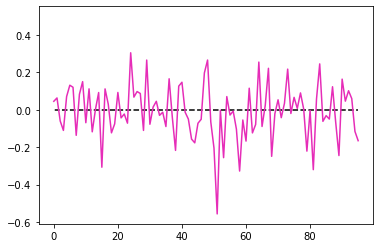

2


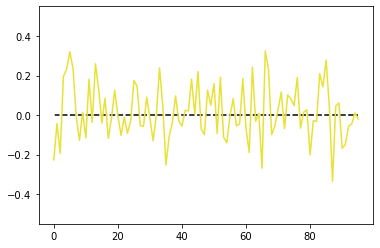

3


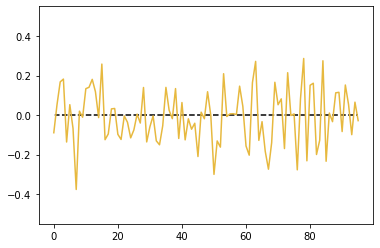

4


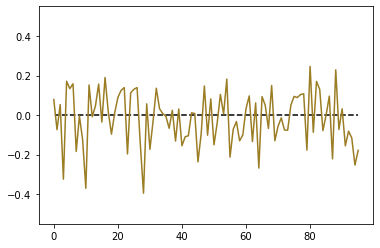

5


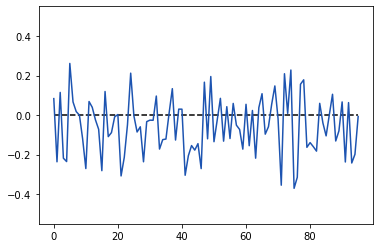

6


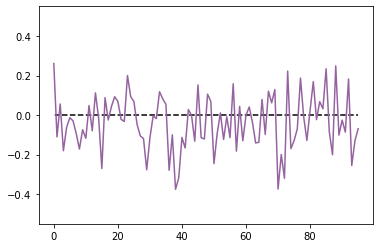

7


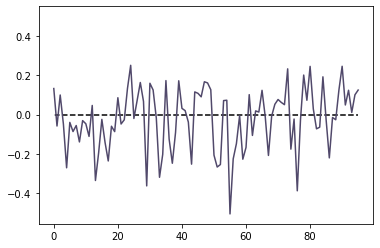

8


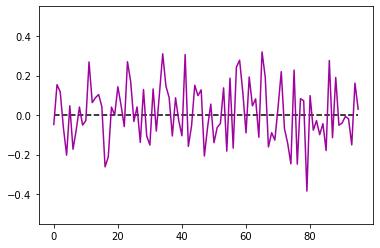

9


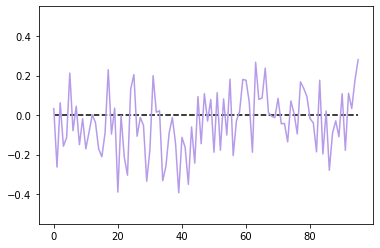

10


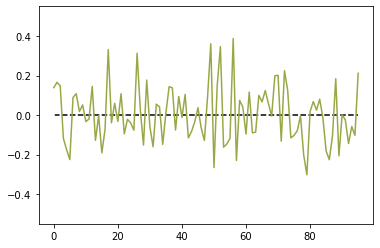

11


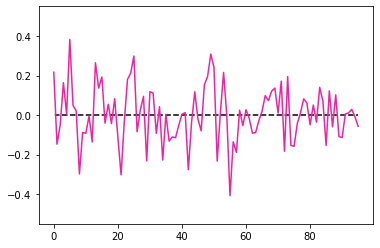

12


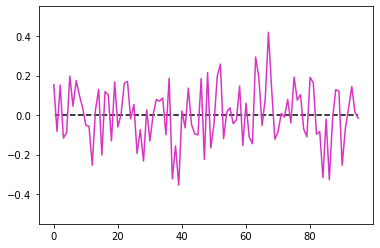

13


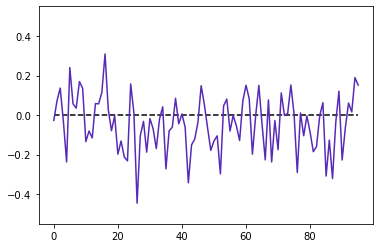

14


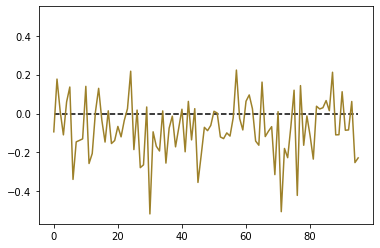

15


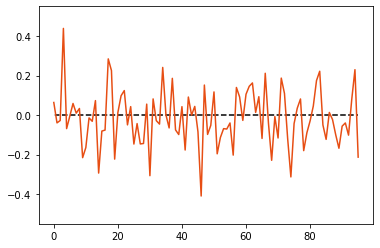

16


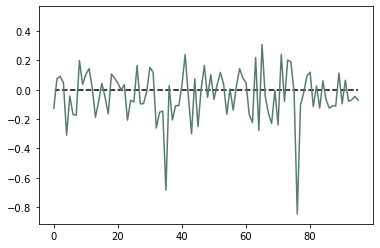

17


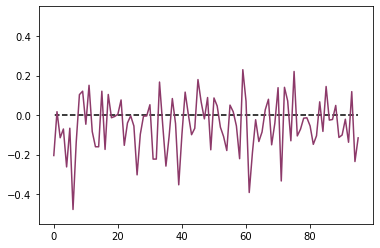

18


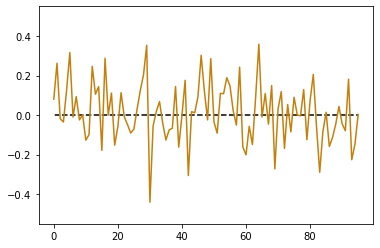

19


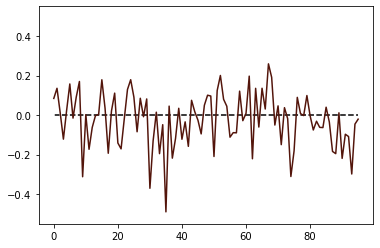

20


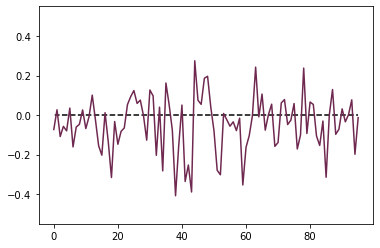

21


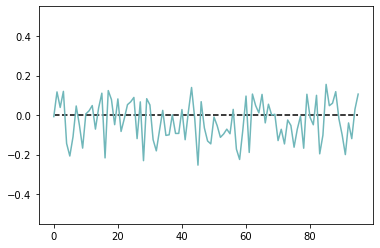

22


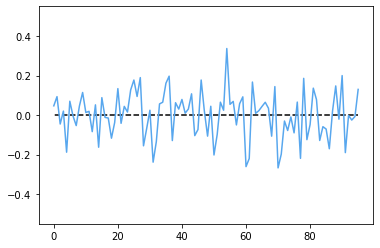

23


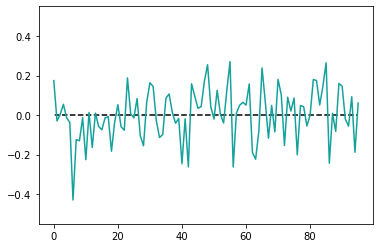

24


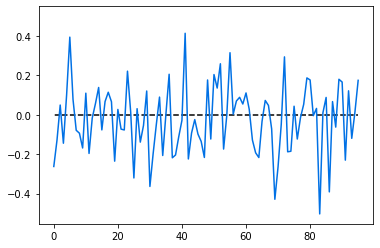

25


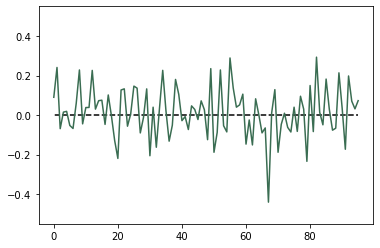

26


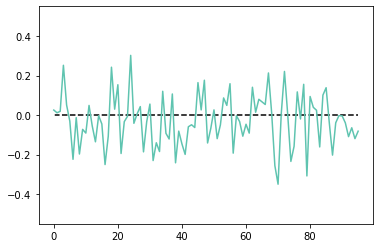

27


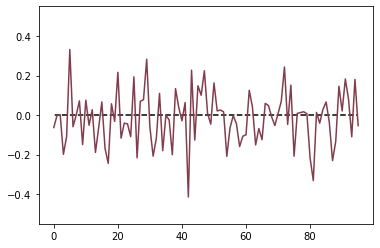

28


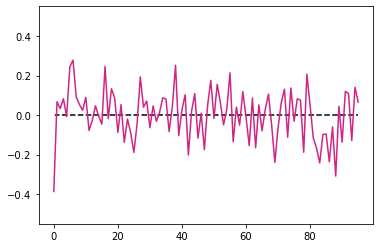

29


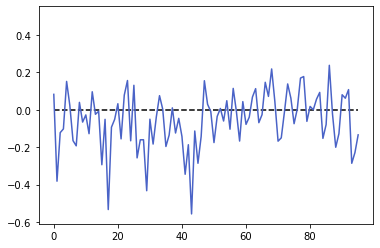

30


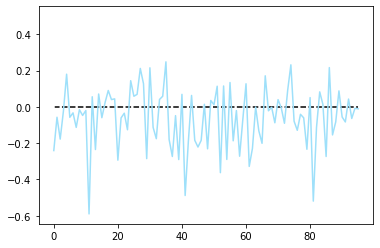

31


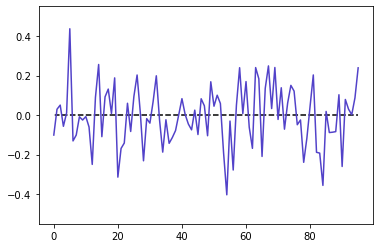

32


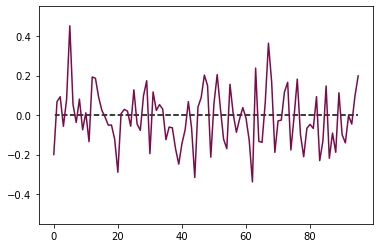

33


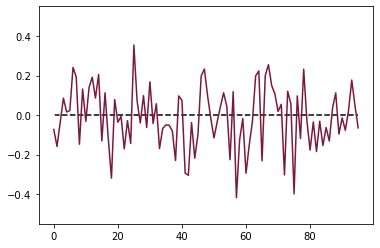

34


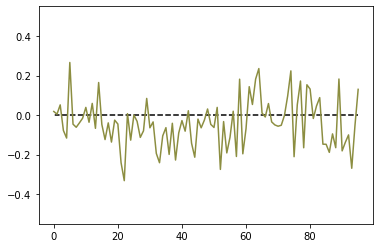

35


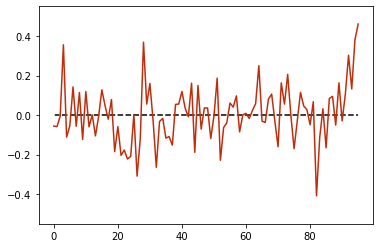

36


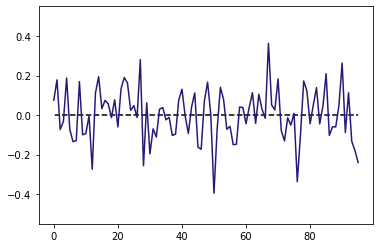

37


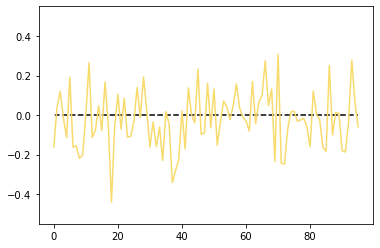

38


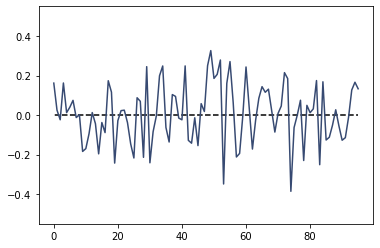

39


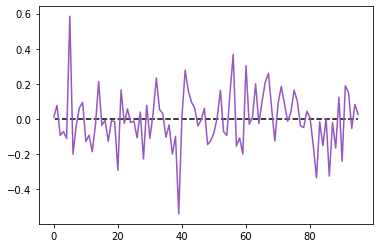

40


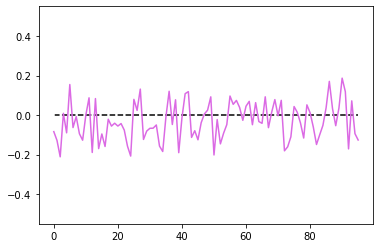

41


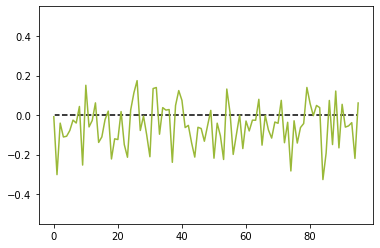

42


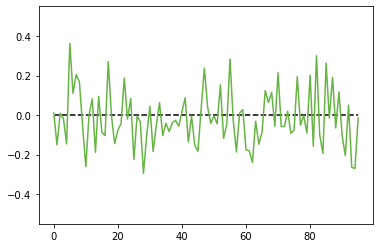

43


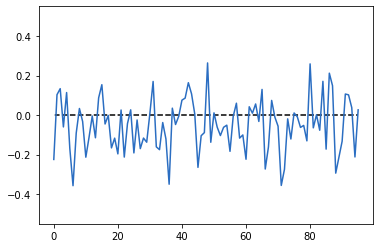

44


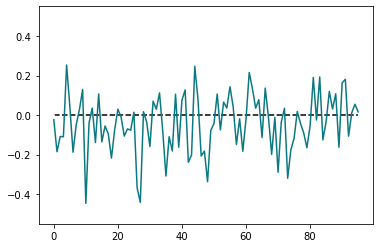

45


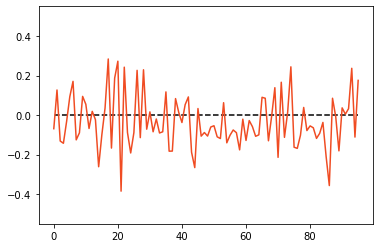

46


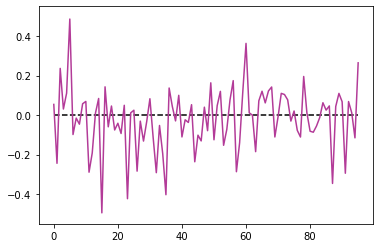

47


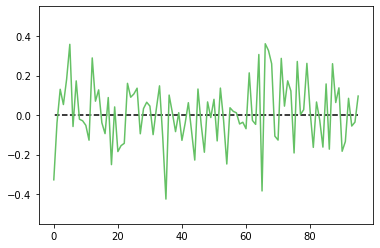

48


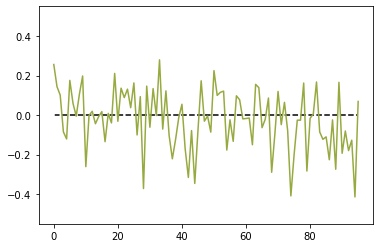

49


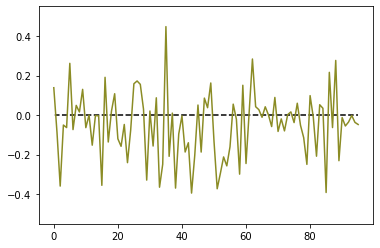

50


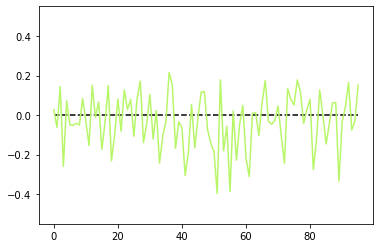

51


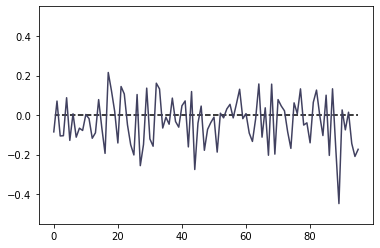

52


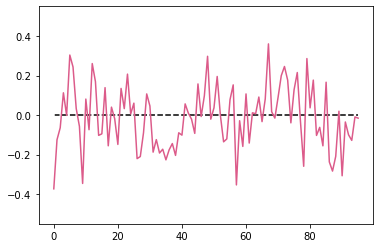

53


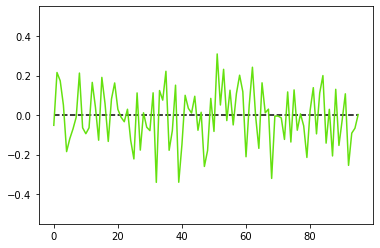

54


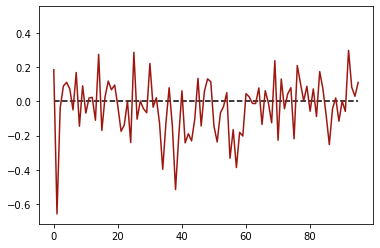

55


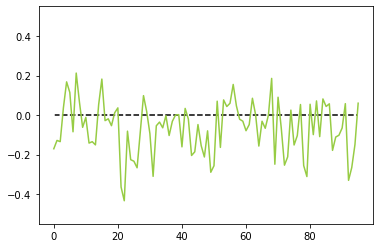

56


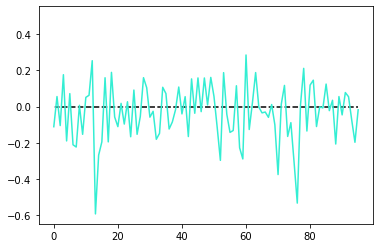

57


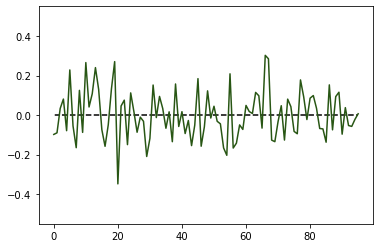

58


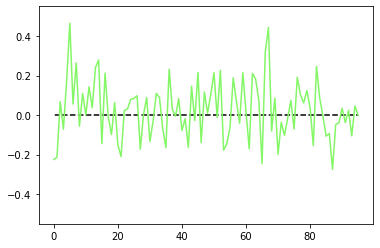

59


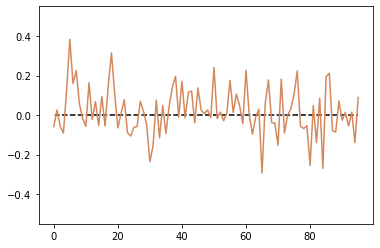

60


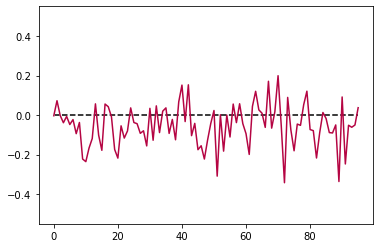

61


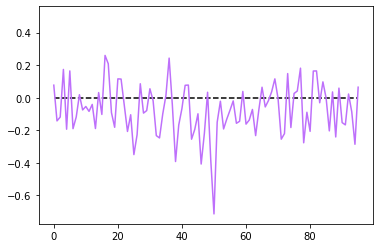

62


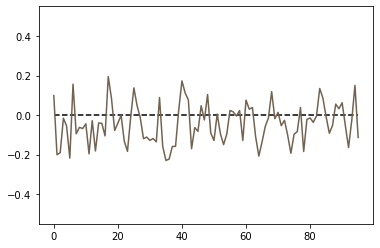

63


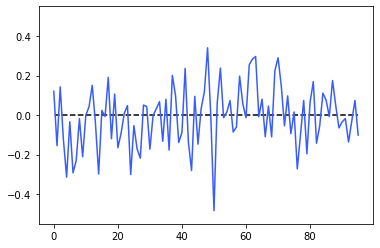

In [66]:
# visualize convolutional layer weights
my_model.layers
cn.plot_convlayer_weights(my_model, layer_num = 1)
cn.plot_denselayer_weights(my_model, layer_num = -3)
